1. Preprocessing

라이브러리 호출

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import plotly.express as px 
from sklearn.impute import KNNImputer
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency
!pip install category_encoders
from category_encoders.hashing import HashingEncoder
from category_encoders import BinaryEncoder

seed = np.random.seed(123)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


드라이브 연결

In [252]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


데이터 불러오기

In [253]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/모델링 후보/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/모델링 후보/test.csv')
submission = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/모델링 후보/submission.csv')

데이터 정보 파악

In [254]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416648 entries, 0 to 416647
Data columns (total 59 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       416648 non-null  int64  
 1   target   416648 non-null  int64  
 2   V1       416648 non-null  int64  
 3   V2_cat   416497 non-null  float64
 4   V3       416648 non-null  int64  
 5   V4_cat   416590 non-null  float64
 6   V5       412565 non-null  float64
 7   V6_bin   416648 non-null  int64  
 8   V7_bin   416648 non-null  int64  
 9   V8_bin   416648 non-null  int64  
 10  V9_bin   416648 non-null  int64  
 11  V10_bin  416648 non-null  int64  
 12  V11_bin  416648 non-null  int64  
 13  V12_bin  416648 non-null  int64  
 14  V13_bin  416648 non-null  int64  
 15  V14      416648 non-null  int64  
 16  V15      416648 non-null  int64  
 17  V16_bin  416648 non-null  int64  
 18  V17_bin  416648 non-null  int64  
 19  V18_bin  416648 non-null  int64  
 20  V19      416648 non-null  

In [255]:
train.head()

,id,target,V1,V2_cat,V3,V4_cat,V5,V6_bin,V7_bin,V8_bin,...,V48,V49,V50,V51,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin
0,1,0,0,1.0,2,1.0,0.0,0,1,0,...,3,0,1,5,0,0,0,0,0,0
1,2,0,1,2.0,2,1.0,0.0,0,1,0,...,2,2,2,1,0,0,0,0,0,0
2,3,0,2,1.0,7,0.0,0.0,1,0,0,...,9,0,2,9,0,1,1,0,1,0
3,4,0,7,1.0,4,1.0,0.0,0,0,1,...,4,1,1,8,0,1,1,0,1,1
4,5,0,0,1.0,5,0.0,0.0,1,0,0,...,5,2,2,7,0,1,1,1,1,0


데이터 타입 지정

In [256]:
main = train.loc[:,["id", "target"]]
bin = train.loc[:,list(train.columns.str[-3:]=='bin')].astype('category')
category = train.loc[:,list(train.columns.str[-3:]=='cat')].astype('category')
numeric = train.loc[:,list(train.columns.str[3:]=='')].drop("id", axis=1)
[len(bin.columns), len(category.columns),len(numeric.columns)]

[17, 13, 27]

데이터 분포 시각화(column 종류별로)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


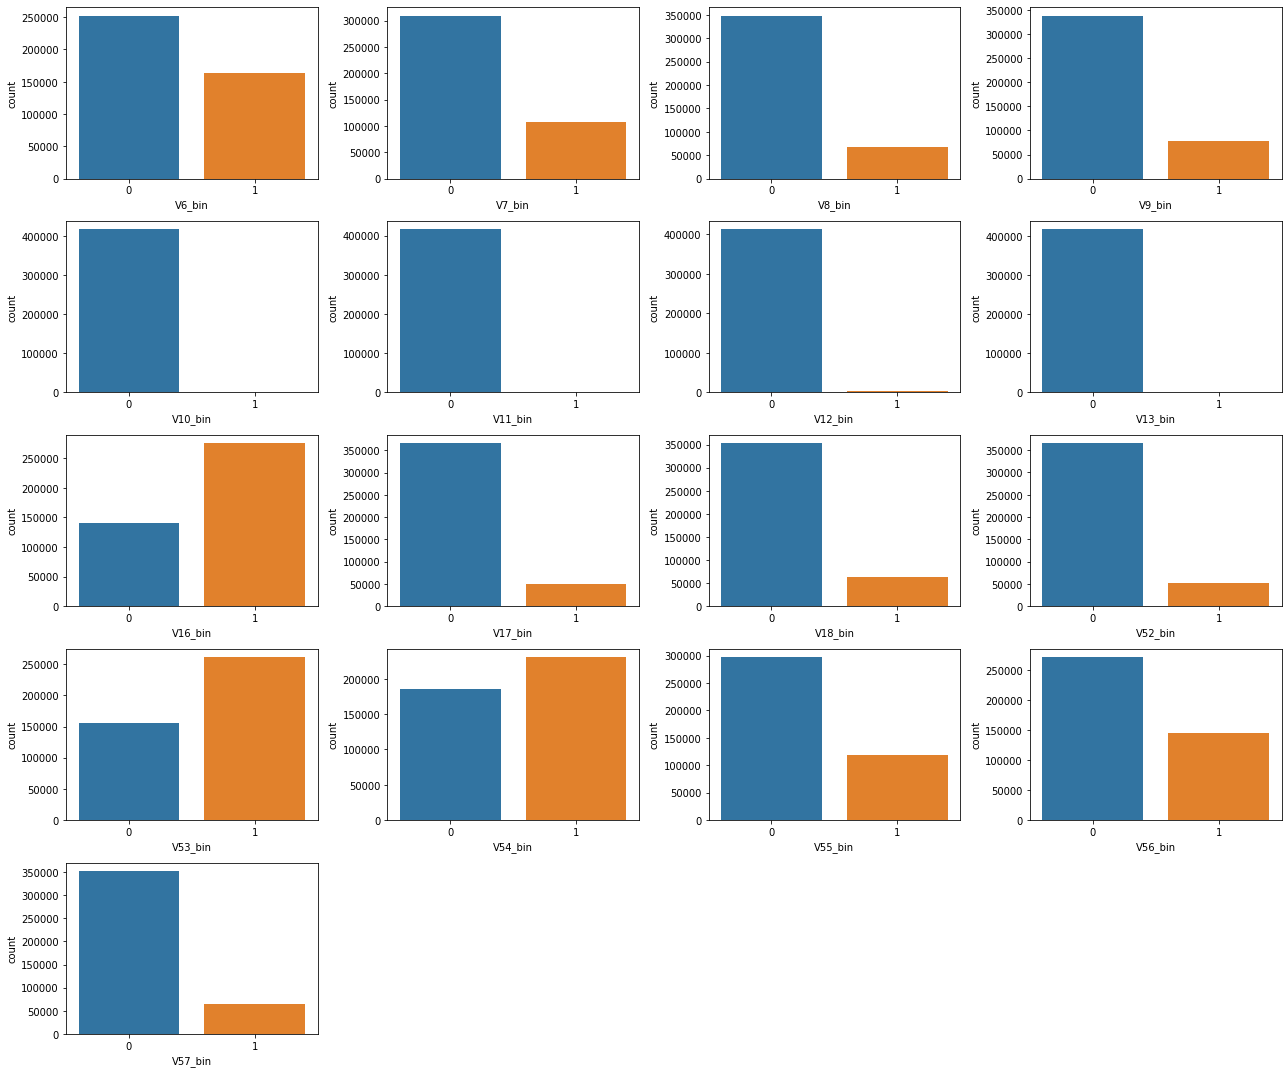

In [257]:
# binary열
plt.figure(figsize=(18, 15))
for idx, col in enumerate(list(bin)):
    plt.subplot(5, 4, idx+1)
    sns.countplot(bin[col])
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


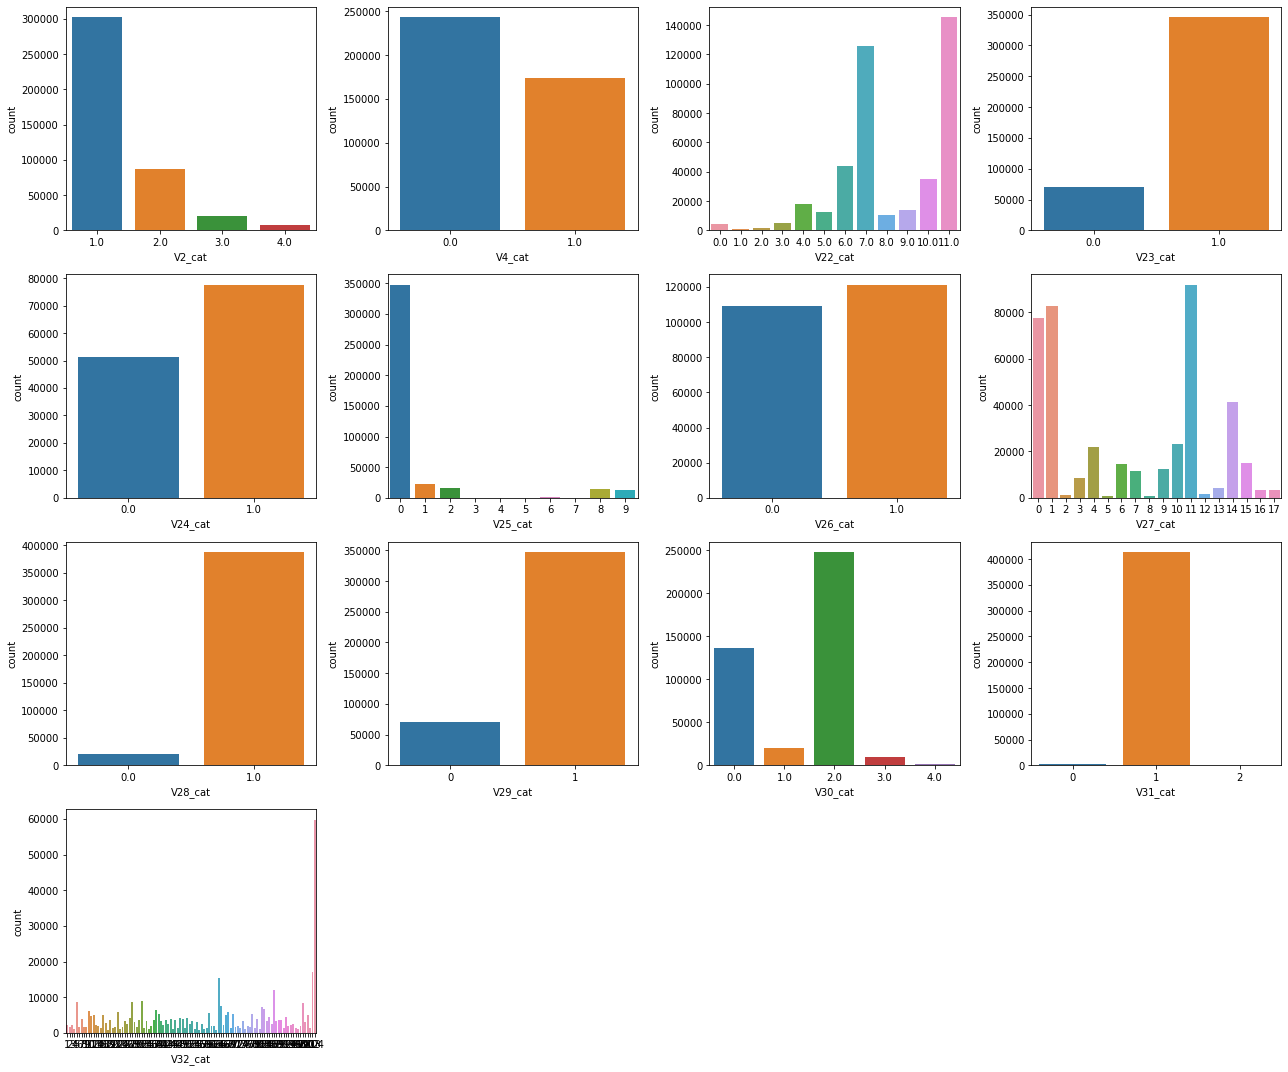

In [258]:
# category열
plt.figure(figsize=(18, 15))
for idx, col in enumerate(list(category)):
    plt.subplot(4, 4, idx+1)
    sns.countplot(category[col])
plt.tight_layout()

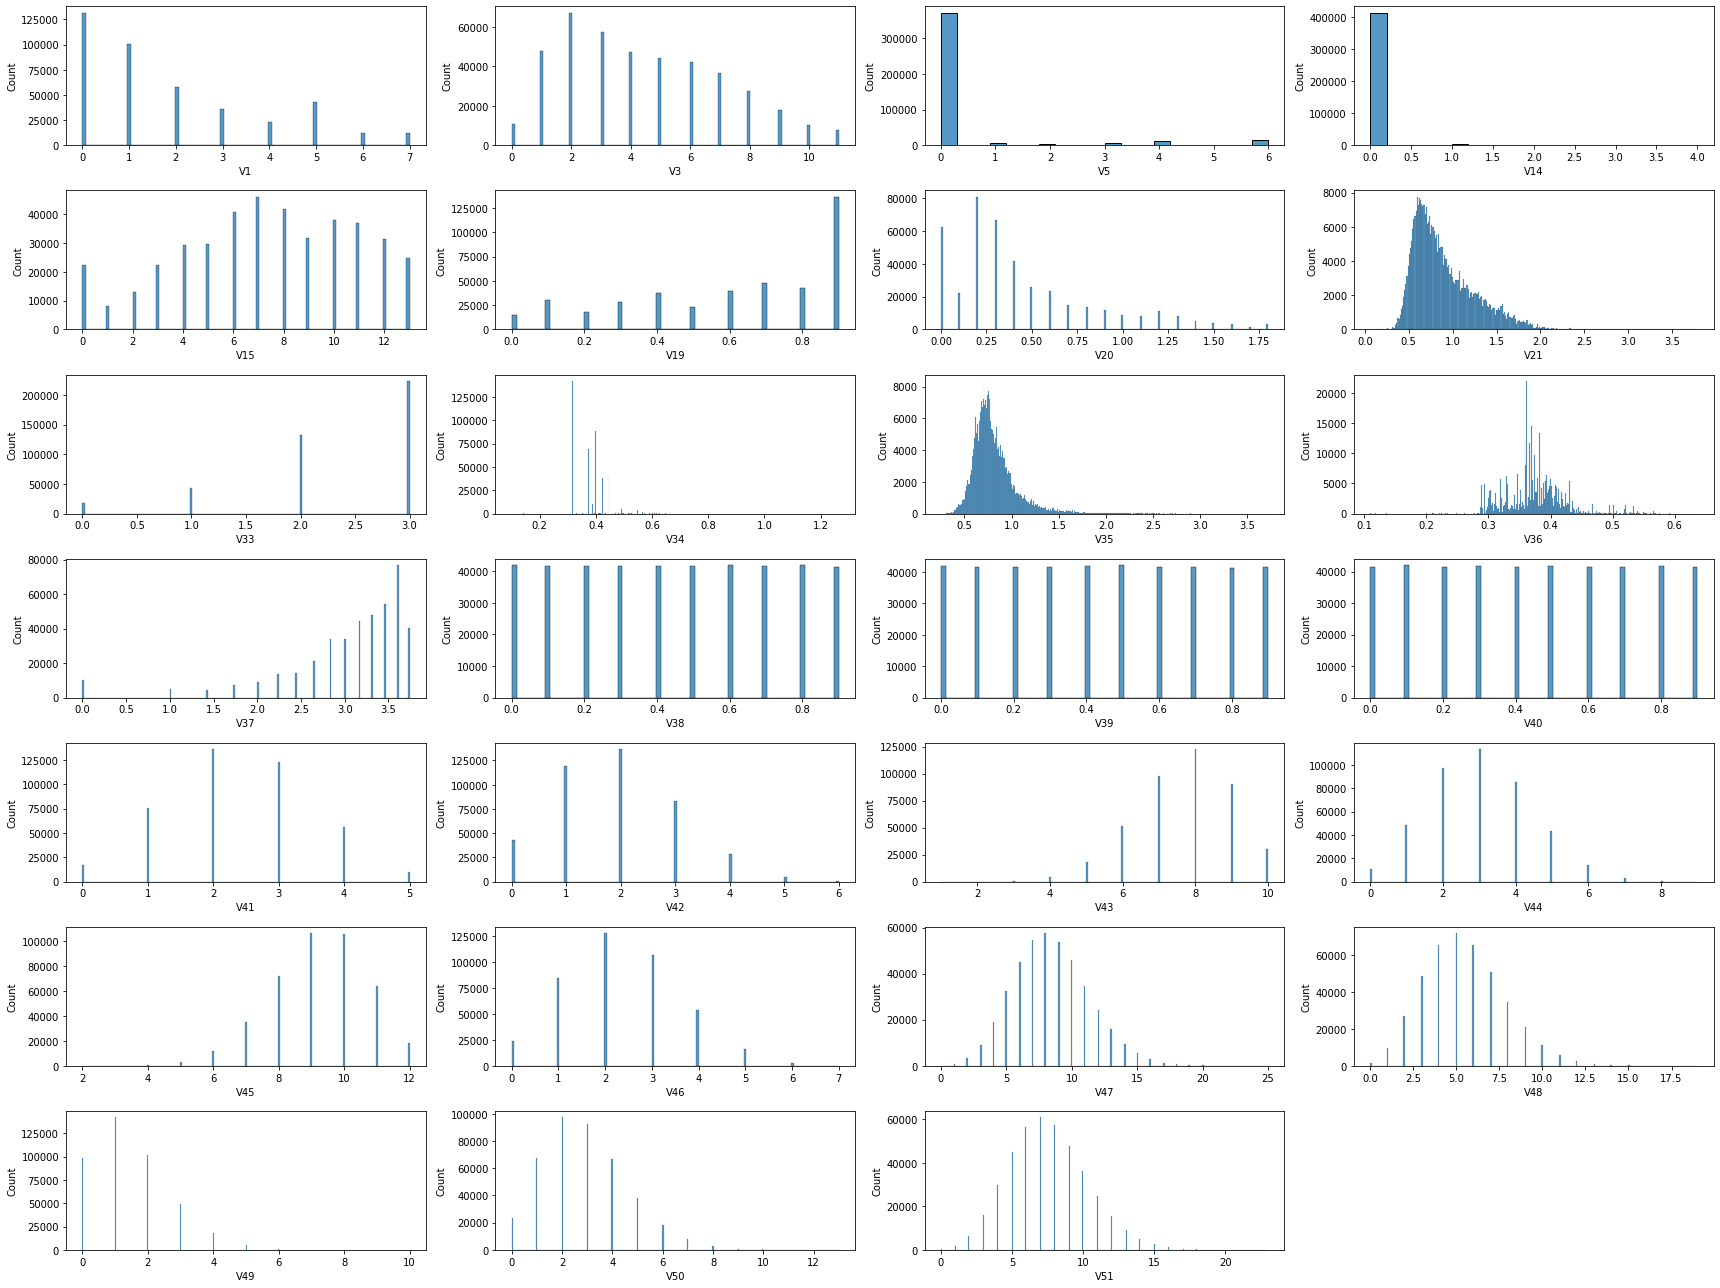

In [259]:
# numeric열
plt.figure(figsize=(24, 18))
for idx, col in enumerate(list(numeric)):
    plt.subplot(7, 4, idx+1)
    sns.histplot(numeric[col])
plt.tight_layout()

NA 개수파악

In [261]:
train.isnull().sum()

id              0
target          0
V1              0
V2_cat        151
V3              0
V4_cat         58
V5           4083
V6_bin          0
V7_bin          0
V8_bin          0
V9_bin          0
V10_bin         0
V11_bin         0
V12_bin         0
V13_bin         0
V14             0
V15             0
V16_bin         0
V17_bin         0
V18_bin         0
V19             0
V20             0
V21         75460
V22_cat        74
V23_cat         4
V24_cat    287761
V25_cat         0
V26_cat    186521
V27_cat         0
V28_cat      8149
V29_cat         0
V30_cat       385
V31_cat         0
V32_cat         0
V33             3
V34             1
V35             0
V36         29831
V37             0
V38             0
V39             0
V40             0
V41             0
V42             0
V43             0
V44             0
V45             0
V46             0
V47             0
V48             0
V49             0
V50             0
V51             0
V52_bin         0
V53_bin         0
V54_bin   

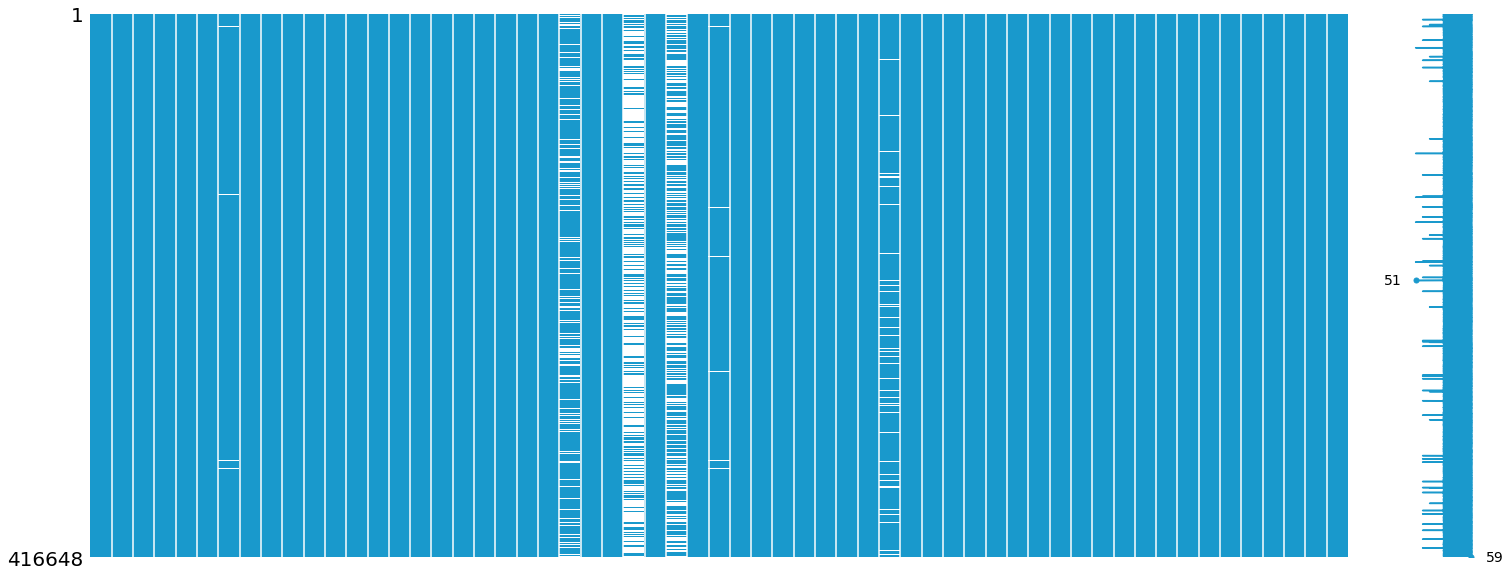

In [262]:
#NA 개수 시각화
msno.matrix(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

In [263]:
#NA 비율 확인
na_col_train = train.isnull().sum().sort_values(ascending=False)/len(train)
na_col_train.head(14)

V24_cat    0.690657
V26_cat    0.447670
V21        0.181112
V36        0.071598
V28_cat    0.019558
V5         0.009800
V30_cat    0.000924
V2_cat     0.000362
V22_cat    0.000178
V4_cat     0.000139
V23_cat    0.000010
V33        0.000007
V34        0.000002
V48        0.000000
dtype: float64

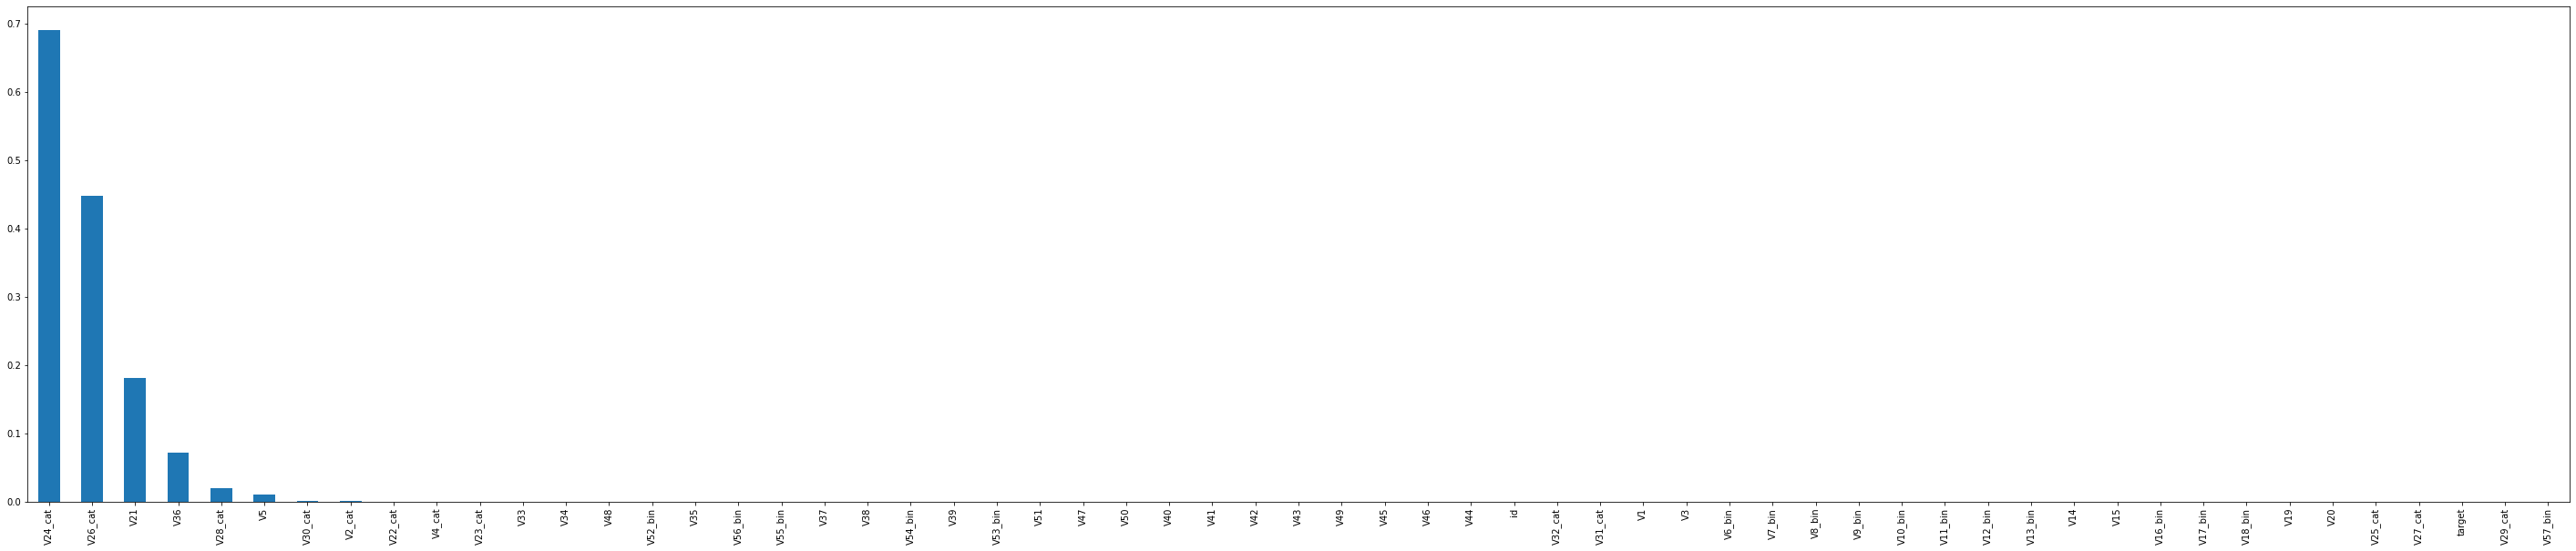

In [264]:
na_col_train.plot.bar(figsize=(50,10))
plt.show()

결측치가 많은 열 제거

In [265]:
train = train.drop(['V24_cat', 'V26_cat'], axis=1) ###결측치가 너무 많은 열 제거 (data의 69%, 44%가 결측치로 이루어져 있어 유의미한 변수가 될 수 없다고 판단)

MICE를 통한 NA imputation 진행

In [266]:
imputer = IterativeImputer(random_state = seed)
mice = imputer.fit(train)

final_train = pd.DataFrame(mice.transform(train))

final_train.isnull().values.any() #MICE 후 결측치 유무 확인

False

In [267]:
final_train

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,...,3.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,...,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,2.0,1.0,7.0,0.0,0.0,1.0,0.0,0.0,...,9.0,0.0,2.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
3,4.0,0.0,7.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,...,4.0,1.0,1.0,8.0,0.0,1.0,1.0,0.0,1.0,1.0
4,5.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,...,5.0,2.0,2.0,7.0,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416643,416644.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,6.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0
416644,416645.0,0.0,5.0,2.0,10.0,1.0,0.0,1.0,0.0,0.0,...,6.0,2.0,5.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0
416645,416646.0,0.0,5.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,...,4.0,3.0,2.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0
416646,416647.0,0.0,0.0,1.0,7.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,2.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0


변수 이름 변경

In [268]:
final_train = final_train.rename(columns = {0: 'id',1:'target', 2:'V1',3:'V2_cat',4: 'V3', 5:'V4_cat',6: 'V5', 7:'V6_bin',8: 'V7_bin',
       9: 'V8_bin', 10: 'V9_bin',11:  'V10_bin', 12: 'V11_bin',13:  'V12_bin',14:  'V13_bin', 15: 'V14', 16: 'V15',17:  'V16_bin', 18: 'V17_bin',19:  'V18_bin',20:  'V19', 21: 'V20', 22: 'V21',23:  'V22_cat',
       24: 'V23_cat',25:  'V25_cat', 26: 'V27_cat', 27:  'V28_cat',28:  'V29_cat',29:  'V30_cat',30: 'V31_cat',31: 'V32_cat', 32: 'V33', 33: 'V34',34:  'V35',35:  'V36', 36:  'V37', 37:  'V38', 38: 'V39',
       39:  'V40', 40: 'V41',41:  'V42',42:  'V43', 43: 'V44',44:  'V45',45:  'V46',46:  'V47', 47: 'V48', 48: 'V49',49:  'V50', 50: 'V51',51:  'V52_bin',52:  'V53_bin', 53: 'V54_bin',54:  'V55_bin', 55: 'V56_bin',56: 'V57_bin'})

class 불균형 파악

In [315]:
final_train['target'].value_counts()

0.0    401419
1.0     15229
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


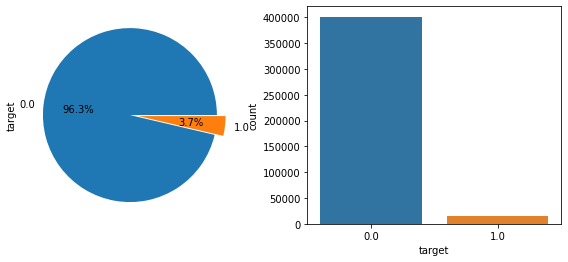

In [319]:
f, ax = plt.subplots(1,2,figsize=(10,4))
final_train['target'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=ax[0]
)

sns.countplot('target', data=final_train, ax=ax[1])
plt.show()

<BarContainer object of 2 artists>

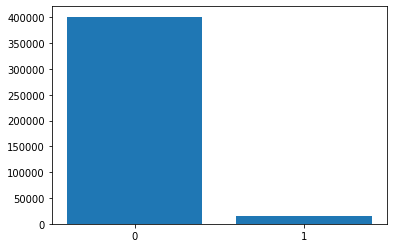

In [320]:
# over-sampling 전
plt.bar(np.arange(2), final_train['target'].value_counts(), tick_label = ['0','1']) 

In [321]:
import imblearn
from imblearn.over_sampling import SMOTE

y = final_train['target']
x = final_train.drop(['target'], axis = 1)

smote = SMOTE(random_state = seed).fit_resample(x, y) #SMOTE 이용

<BarContainer object of 2 artists>

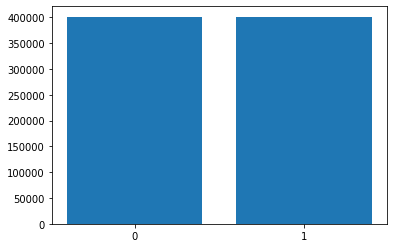

In [322]:
resample_x = pd.DataFrame(smote[0])
resample_y = pd.DataFrame(smote[1])
resample_y.columns = [1]
data = pd.concat([resample_x, resample_y], axis = 1)

# over-sampling 후
plt.bar(np.arange(2), data[1].value_counts(), tick_label = ['0','1'])

data type 재변경

In [269]:
final_train_cols = list(final_train.columns)
list_binary = []
list_category = []

for col in final_train_cols:
    try:
        if col.split("_")[1] == "bin":
            list_binary.append(col)
        elif col.split("_")[1] == "cat":
            list_category.append(col)
    except:
        pass

list_numeric = list(set(final_train_cols) - set(list_binary + list_category))

In [270]:
list_category

for name in list_category:
  final_train[name] = final_train[name].astype('int')
  final_train[name] = final_train[name].astype('category')

list_category

for name in list_binary:
  final_train[name] = final_train[name].astype('int')
  final_train[name] = final_train[name].astype('category')

NA mputation 진행 후 분포 변화 비교

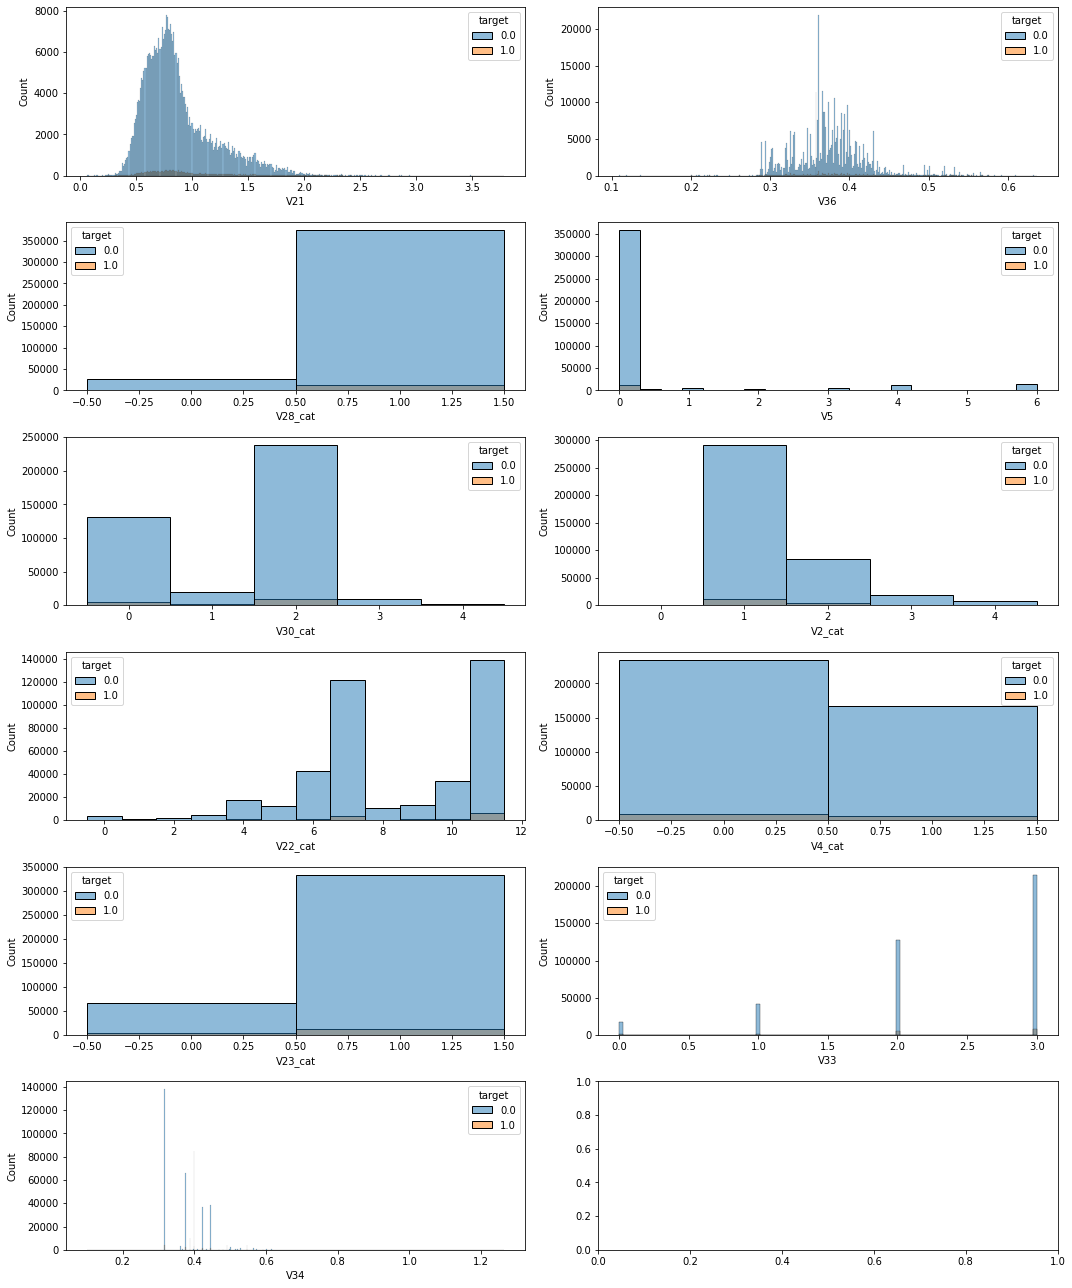

In [271]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(15,18))

sns.histplot(ax=axes[0,0], x="V21", hue="target", data=final_train)
sns.histplot(ax=axes[0,1], x="V36", hue="target", data=final_train)
sns.histplot(ax=axes[1,0], x="V28_cat", hue="target", data=final_train)
sns.histplot(ax=axes[1,1], x="V5", hue="target",data=final_train)
sns.histplot(ax=axes[2,0], x="V30_cat", hue="target", data=final_train)
sns.histplot(ax=axes[2,1], x="V2_cat", hue="target", data=final_train)
sns.histplot(ax=axes[3,0], x="V22_cat", hue="target", data=final_train)
sns.histplot(ax=axes[3,1], x="V4_cat", hue="target", data=final_train)
sns.histplot(ax=axes[4,0], x="V23_cat", hue="target", data=final_train)
sns.histplot(ax=axes[4,1], x="V33", hue="target", data=final_train)
sns.histplot(ax=axes[5,0], x="V34", hue="target", data=final_train)

fig.tight_layout()

plt.show()

NA imputation 후 변수별 상관관계 비교를 위한 사전정리

In [272]:
list_control = ["V4_cat", "V23_cat", "V28_cat", "V29_cat"] 
#binary data인데 category 항목에 있는 열들 ## 결측치 비율이 높았던 V24_cat, V23_cat열은 제거한 상태

### category에서 제거
for i in list_control:
    list_category.remove(i)

## binary에 추가
for i in list_control:
    list_binary.append(i)

list_numeric.remove("target")
list_target=["target"]

In [273]:
## 범주형 변수 타입 변경
final_train["target"] = final_train["target"].astype('category')

for name in list_category:
    final_train[name] = final_train[name].astype('category')
for name in list_binary:
    final_train[name] = final_train[name].astype('category')

In [274]:
target = final_train[list_target]
category = final_train[list_category]
binary = final_train[list_binary]
numeric = final_train[list_numeric]
nominal = pd.concat([binary, category], axis=1)
[len(list_target), len(list_category), len(list_binary), len(list_numeric)]

[1, 7, 21, 28]

범주형 변수 상관관계 파악

In [275]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/pivot.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agged[v] = maybe_downcast_to_dtype(agged[v], data[v].dtype)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


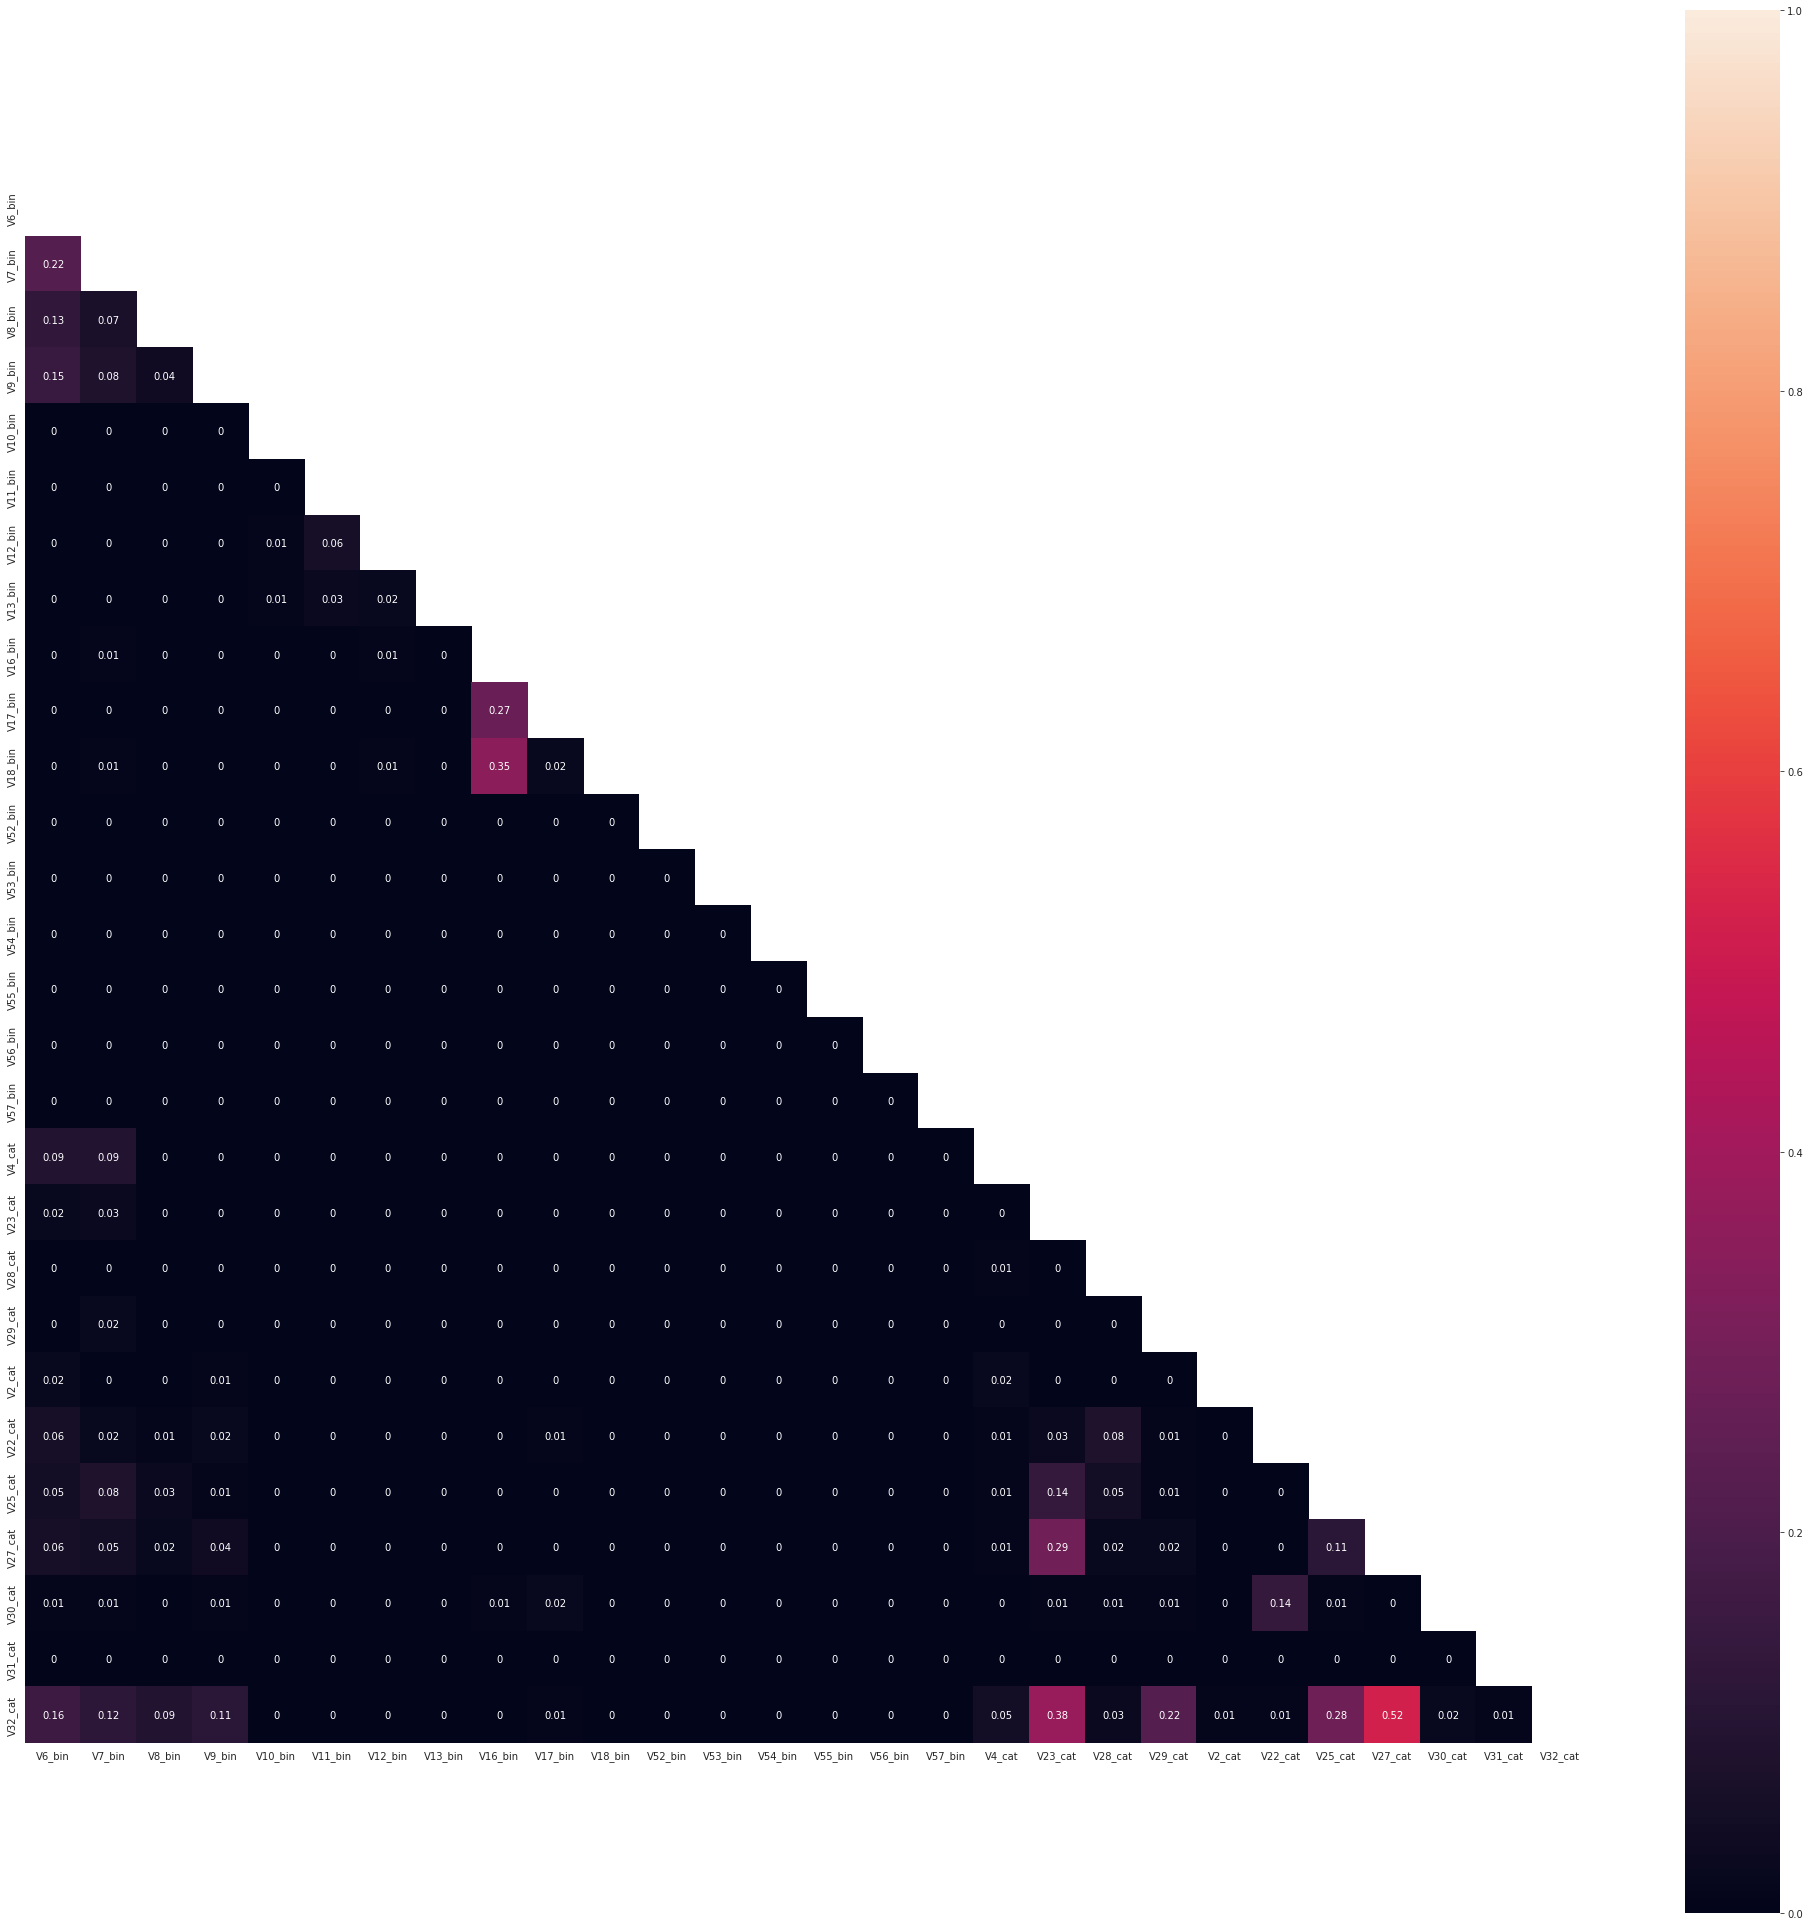

In [276]:
rows= []

for var1 in nominal:
  col = []
  for var2 in nominal :
    cramers =cramers_V(nominal[var1], nominal[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df1 = pd.DataFrame(cramers_results, columns = nominal.columns, index = nominal.columns)

mask1 = np.zeros_like(df1, dtype=np.bool)
mask1[np.triu_indices_from(mask1)] = True

plt.figure(figsize=(35,35))
with sns.axes_style("white"):
  ax = sns.heatmap(df1, mask=mask1, vmin=0., vmax=1, square=True, annot=True)
plt.show() ###제거할만한 유의미한 상관관계를 지닌 범주형 변수가 없음

수치형 변수 상관관계 비교

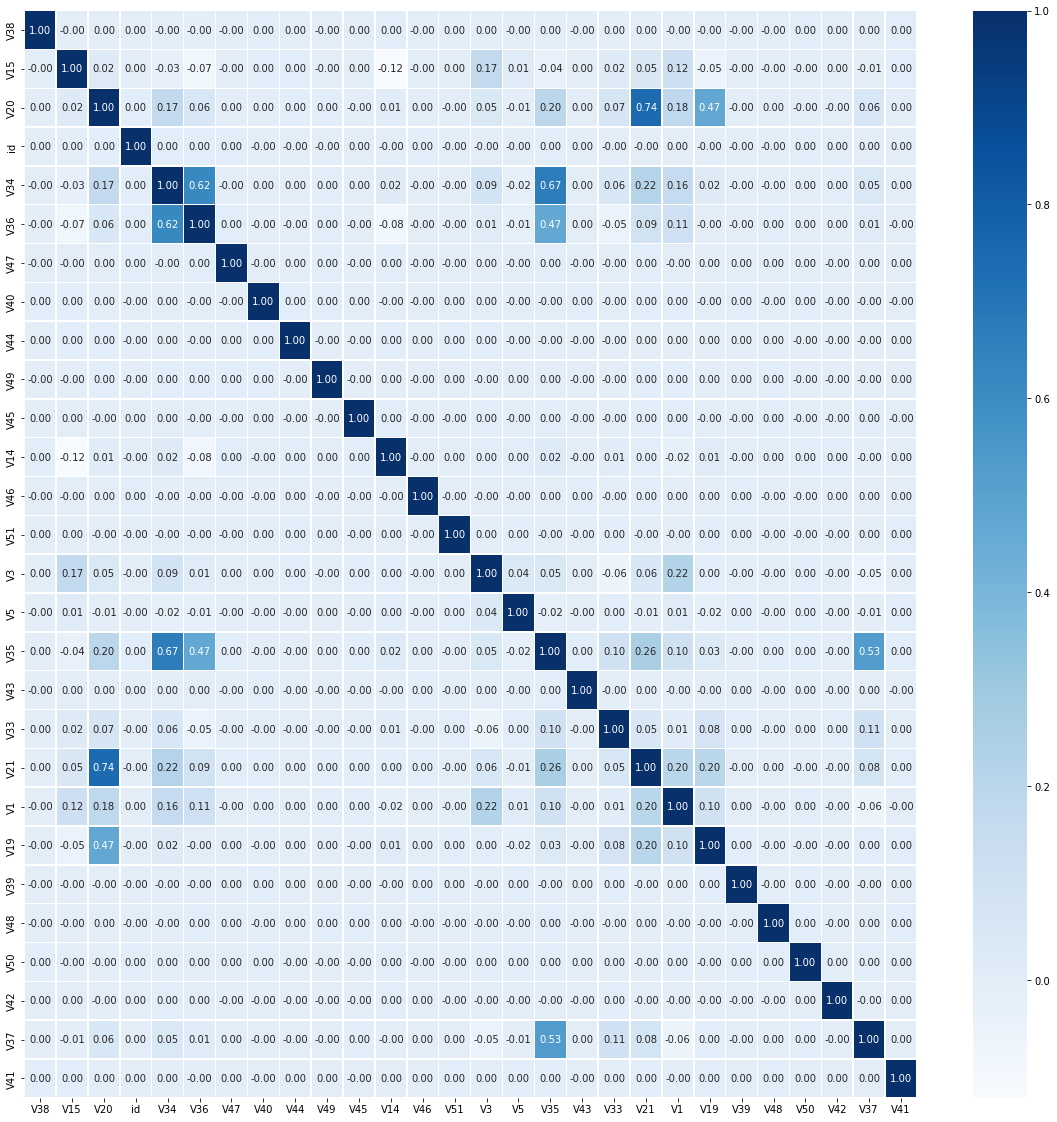

In [277]:
cor = numeric.corr(method = 'pearson')
plt.figure(figsize=(20,20))
sns.heatmap(cor, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

범주의 개수가 많은 열에 대한 hash encoding 진행
(hash encoding : encoding을 진행하면서도 column의 개수가 지나치게 많아지는 것을 방지)

In [278]:
## categorical에서 V32_cat의 경우 hash encoding 진행

## sklearn의 HashingEncoder 사용
"""
HashingEncoder(n_components = UserNumber, cols=["User Columns"], hash_method='md5', max_process = 1)

n_components: 차원
cols: 원하는 열
max_process: 프로세스 사용 개수

#(data_set, columns = ["V32_cat"])

# X = data_set.drop("target", axis = 1)
# y = data_set["target"]
"""


X = final_train
hashencoding = HashingEncoder(cols = ["V32_cat"], n_components=5 ).fit(X)
data_hashencoding = hashencoding.transform(X)

### V32_cat 은 category 에서 제거해야지!!
list_category.remove("V32_cat") ## V32_cat은 제거한다.

In [279]:
final_train_hashencoding = data_hashencoding.rename(columns = {"col_0":"V32_cat_0", "col_1":"V32_cat_1", "col_2":"V32_cat_2", "col_3":"V32_cat_3", "col_4":"V32_cat_4"})

In [280]:
final_train_hashencoding

,V32_cat_0,V32_cat_1,V32_cat_2,V32_cat_3,V32_cat_4,id,target,V1,V2_cat,V3,...,V48,V49,V50,V51,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin
0,0,1,0,0,0,1.0,0.0,0.0,1,2.0,...,3.0,0.0,1.0,5.0,0,0,0,0,0,0
1,0,0,1,0,0,2.0,0.0,1.0,2,2.0,...,2.0,2.0,2.0,1.0,0,0,0,0,0,0
2,0,0,0,1,0,3.0,0.0,2.0,1,7.0,...,9.0,0.0,2.0,9.0,0,1,1,0,1,0
3,0,0,0,0,1,4.0,0.0,7.0,1,4.0,...,4.0,1.0,1.0,8.0,0,1,1,0,1,1
4,0,0,0,0,1,5.0,0.0,0.0,1,5.0,...,5.0,2.0,2.0,7.0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416643,0,0,0,0,1,416644.0,0.0,0.0,1,2.0,...,2.0,1.0,6.0,6.0,0,0,1,0,0,0
416644,0,0,1,0,0,416645.0,0.0,5.0,2,10.0,...,6.0,2.0,5.0,4.0,0,1,1,0,0,0
416645,0,0,0,0,1,416646.0,0.0,5.0,1,4.0,...,4.0,3.0,2.0,4.0,0,1,1,0,1,0
416646,0,0,0,0,1,416647.0,0.0,0.0,1,7.0,...,3.0,1.0,2.0,7.0,0,1,0,0,0,0


열 이름 재정리

In [281]:
final_train = final_train_hashencoding[['id',
       'target', 'V1', 'V2_cat', 'V3', 'V4_cat', 'V5', 'V6_bin', 'V7_bin',
       'V8_bin', 'V9_bin', 'V10_bin', 'V11_bin', 'V12_bin', 'V13_bin', 'V14',
       'V15', 'V16_bin', 'V17_bin', 'V18_bin', 'V19', 'V20', 'V21', 'V22_cat',
       'V23_cat', 'V25_cat', 'V27_cat', 'V28_cat', 'V29_cat',
       'V30_cat', 'V31_cat','V32_cat_0', 'V32_cat_1', 'V32_cat_2', 'V32_cat_3', 'V32_cat_4', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V41', 'V42', 
       'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52_bin', 'V53_bin', 'V54_bin', 'V55_bin','V56_bin', 'V57_bin']]

최종 데이터셋!!!

In [282]:
final_train

,id,target,V1,V2_cat,V3,V4_cat,V5,V6_bin,V7_bin,V8_bin,...,V48,V49,V50,V51,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin
0,1.0,0.0,0.0,1,2.0,1,0.0,0,1,0,...,3.0,0.0,1.0,5.0,0,0,0,0,0,0
1,2.0,0.0,1.0,2,2.0,1,0.0,0,1,0,...,2.0,2.0,2.0,1.0,0,0,0,0,0,0
2,3.0,0.0,2.0,1,7.0,0,0.0,1,0,0,...,9.0,0.0,2.0,9.0,0,1,1,0,1,0
3,4.0,0.0,7.0,1,4.0,1,0.0,0,0,1,...,4.0,1.0,1.0,8.0,0,1,1,0,1,1
4,5.0,0.0,0.0,1,5.0,0,0.0,1,0,0,...,5.0,2.0,2.0,7.0,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416643,416644.0,0.0,0.0,1,2.0,0,0.0,0,0,0,...,2.0,1.0,6.0,6.0,0,0,1,0,0,0
416644,416645.0,0.0,5.0,2,10.0,1,0.0,1,0,0,...,6.0,2.0,5.0,4.0,0,1,1,0,0,0
416645,416646.0,0.0,5.0,1,4.0,1,0.0,0,1,0,...,4.0,3.0,2.0,4.0,0,1,1,0,1,0
416646,416647.0,0.0,0.0,1,7.0,0,0.0,1,0,0,...,3.0,1.0,2.0,7.0,0,1,0,0,0,0


In [283]:
final_train.to_csv('final_train.csv', index = False)

### test data 전처리

In [284]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178564 entries, 0 to 178563
Data columns (total 58 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       178564 non-null  int64  
 1   V1       178564 non-null  int64  
 2   V2_cat   178499 non-null  float64
 3   V3       178564 non-null  int64  
 4   V4_cat   178539 non-null  float64
 5   V5       176838 non-null  float64
 6   V6_bin   178564 non-null  int64  
 7   V7_bin   178564 non-null  int64  
 8   V8_bin   178564 non-null  int64  
 9   V9_bin   178564 non-null  int64  
 10  V10_bin  178564 non-null  int64  
 11  V11_bin  178564 non-null  int64  
 12  V12_bin  178564 non-null  int64  
 13  V13_bin  178564 non-null  int64  
 14  V14      178564 non-null  int64  
 15  V15      178564 non-null  int64  
 16  V16_bin  178564 non-null  int64  
 17  V17_bin  178564 non-null  int64  
 18  V18_bin  178564 non-null  int64  
 19  V19      178564 non-null  float64
 20  V20      178564 non-null  

In [285]:
test.head()

,id,V1,V2_cat,V3,V4_cat,V5,V6_bin,V7_bin,V8_bin,V9_bin,...,V48,V49,V50,V51,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin
0,1,0,2.0,6,0.0,0.0,0,0,0,1,...,8,0,2,3,0,1,1,0,1,0
1,2,3,1.0,4,0.0,0.0,1,0,0,0,...,9,0,9,8,0,0,0,1,1,0
2,3,1,2.0,1,1.0,0.0,0,0,0,1,...,2,0,4,8,0,0,1,0,1,0
3,4,1,3.0,2,1.0,0.0,1,0,0,0,...,8,0,4,5,0,1,0,1,1,0
4,5,1,1.0,1,0.0,0.0,0,1,0,0,...,3,1,5,8,0,1,0,1,0,0


In [287]:
main = test.loc[:,["id"]]
bin = test.loc[:,list(test.columns.str[-3:]=='bin')].astype('category')
category = test.loc[:,list(test.columns.str[-3:]=='cat')].astype('category')
numeric = test.loc[:,list(test.columns.str[3:]=='')].drop("id", axis=1)
[len(bin.columns), len(category.columns),len(numeric.columns)]

[17, 13, 27]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


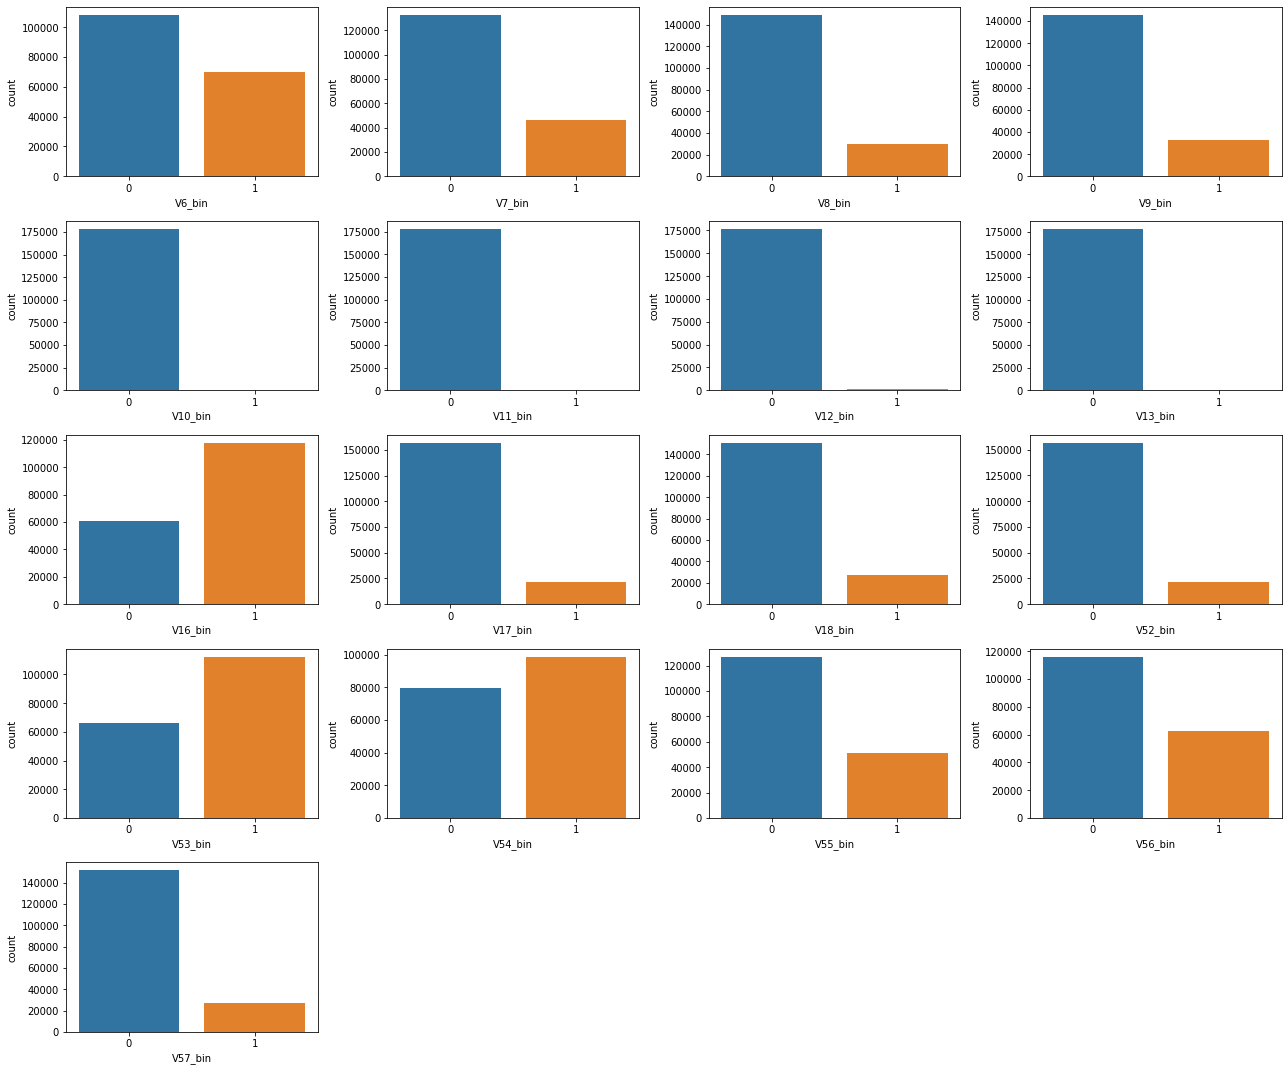

In [288]:
# binary열
plt.figure(figsize=(18, 15))
for idx, col in enumerate(list(bin)):
    plt.subplot(5, 4, idx+1)
    sns.countplot(bin[col])
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


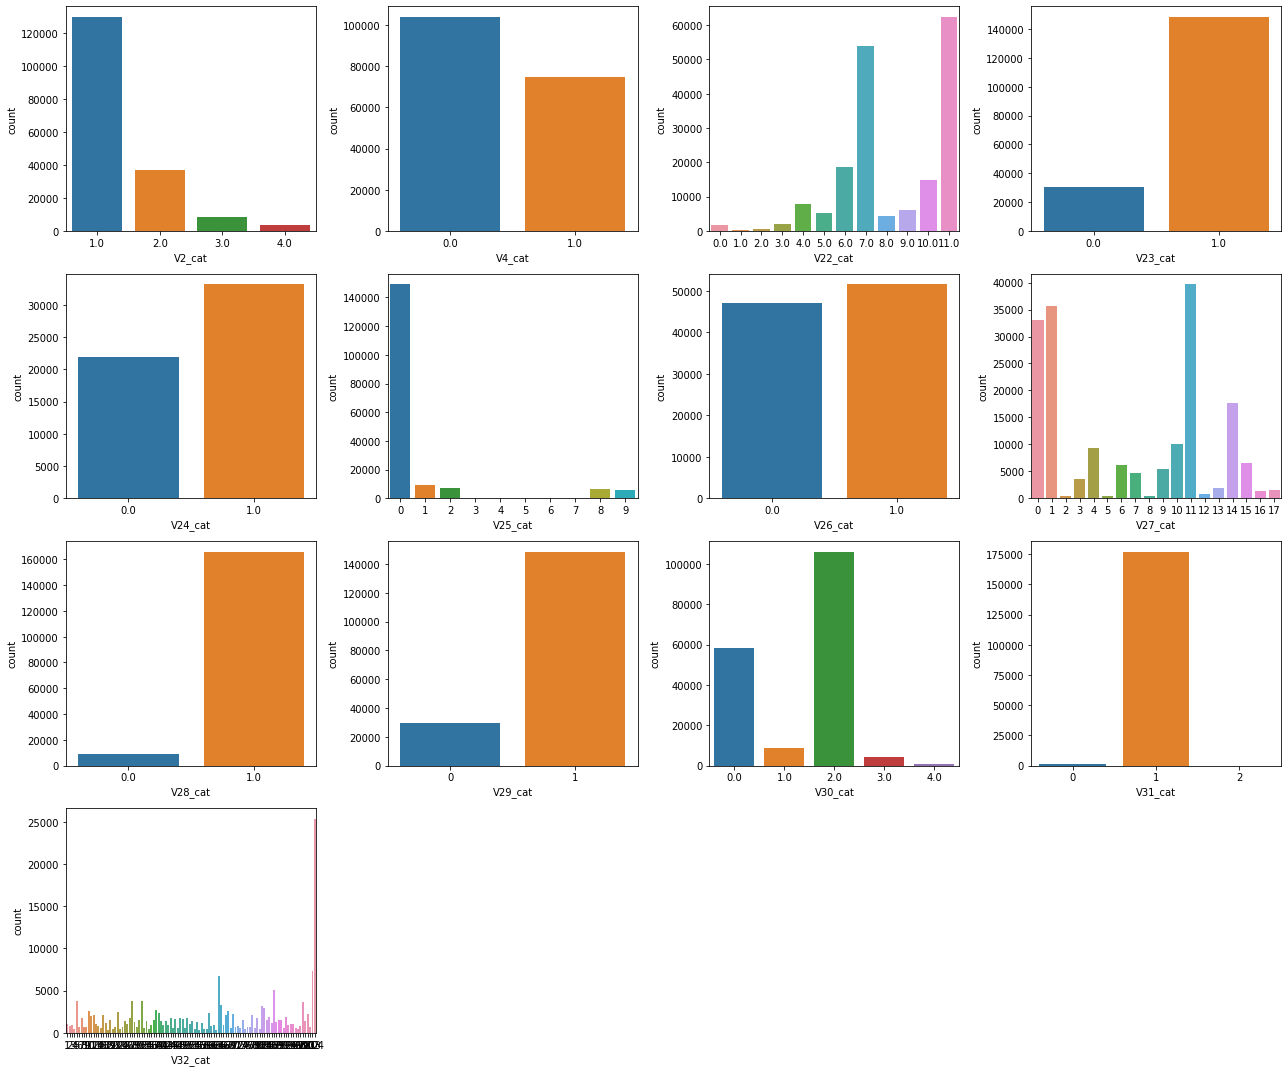

In [289]:
# category열
plt.figure(figsize=(18, 15))
for idx, col in enumerate(list(category)):
    plt.subplot(4, 4, idx+1)
    sns.countplot(category[col])
plt.tight_layout()

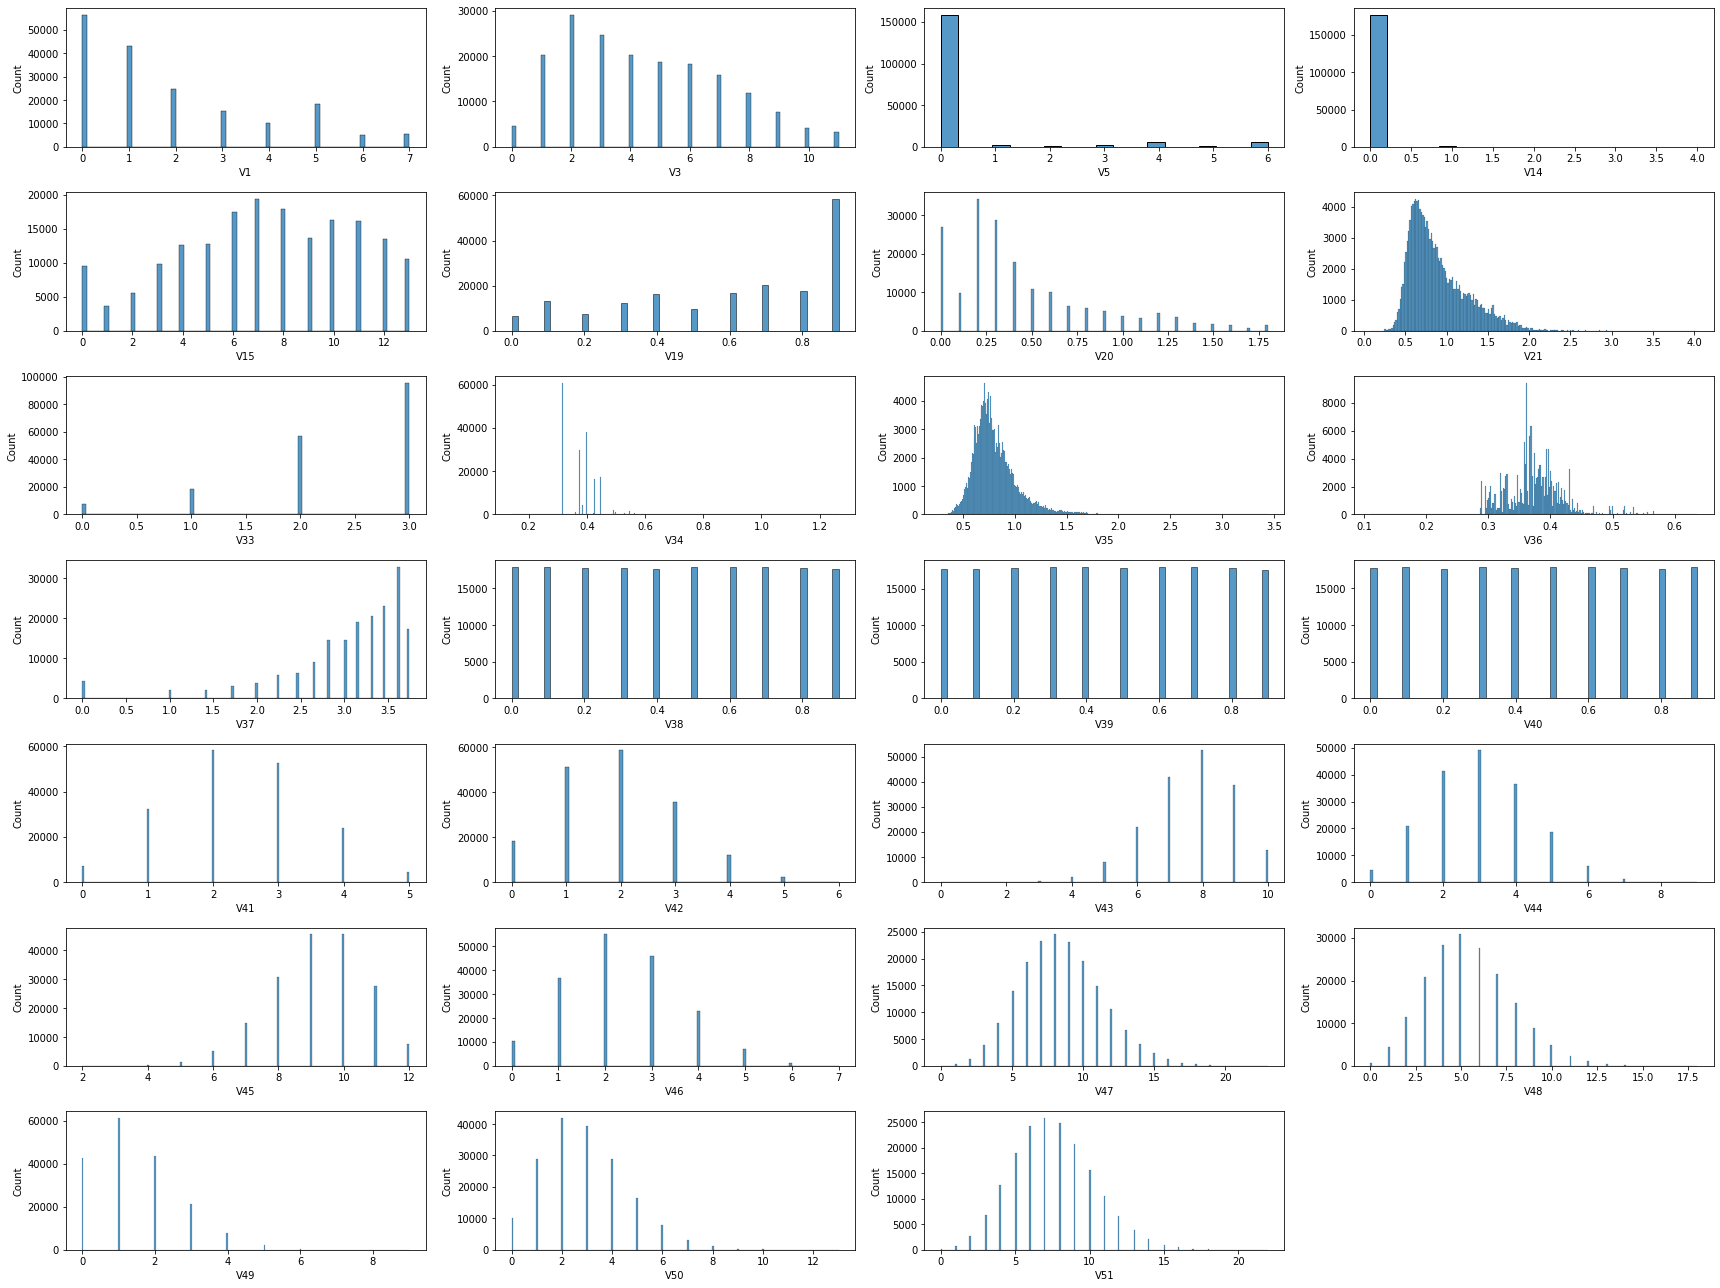

In [290]:
# numeric열
plt.figure(figsize=(24, 18))
for idx, col in enumerate(list(numeric)):
    plt.subplot(7, 4, idx+1)
    sns.histplot(numeric[col])
plt.tight_layout()

In [291]:
test.isnull().sum()

id              0
V1              0
V2_cat         65
V3              0
V4_cat         25
V5           1726
V6_bin          0
V7_bin          0
V8_bin          0
V9_bin          0
V10_bin         0
V11_bin         0
V12_bin         0
V13_bin         0
V14             0
V15             0
V16_bin         0
V17_bin         0
V18_bin         0
V19             0
V20             0
V21         32312
V22_cat        33
V23_cat         1
V24_cat    123470
V25_cat         0
V26_cat     80030
V27_cat         0
V28_cat      3340
V29_cat         0
V30_cat       184
V31_cat         0
V32_cat         0
V33             2
V34             0
V35             0
V36         12789
V37             0
V38             0
V39             0
V40             0
V41             0
V42             0
V43             0
V44             0
V45             0
V46             0
V47             0
V48             0
V49             0
V50             0
V51             0
V52_bin         0
V53_bin         0
V54_bin         0
V55_bin   

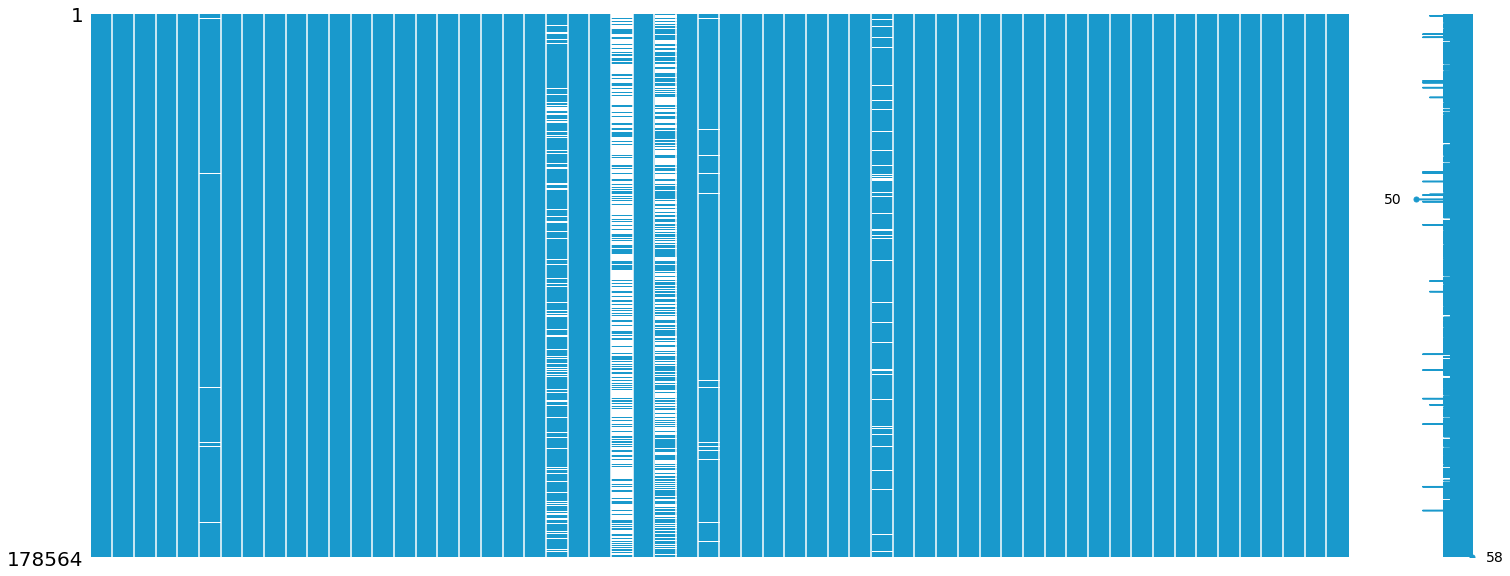

In [292]:
msno.matrix(df=test.iloc[:, :], color=(0.1, 0.6, 0.8))

In [293]:
#NA 비율 확인
na_col_test = test.isnull().sum().sort_values(ascending=False)/len(test)
na_col_test.head(14)

V24_cat    0.691461
V26_cat    0.448187
V21        0.180955
V36        0.071621
V28_cat    0.018705
V5         0.009666
V30_cat    0.001030
V2_cat     0.000364
V22_cat    0.000185
V4_cat     0.000140
V33        0.000011
V23_cat    0.000006
V39        0.000000
V40        0.000000
dtype: float64

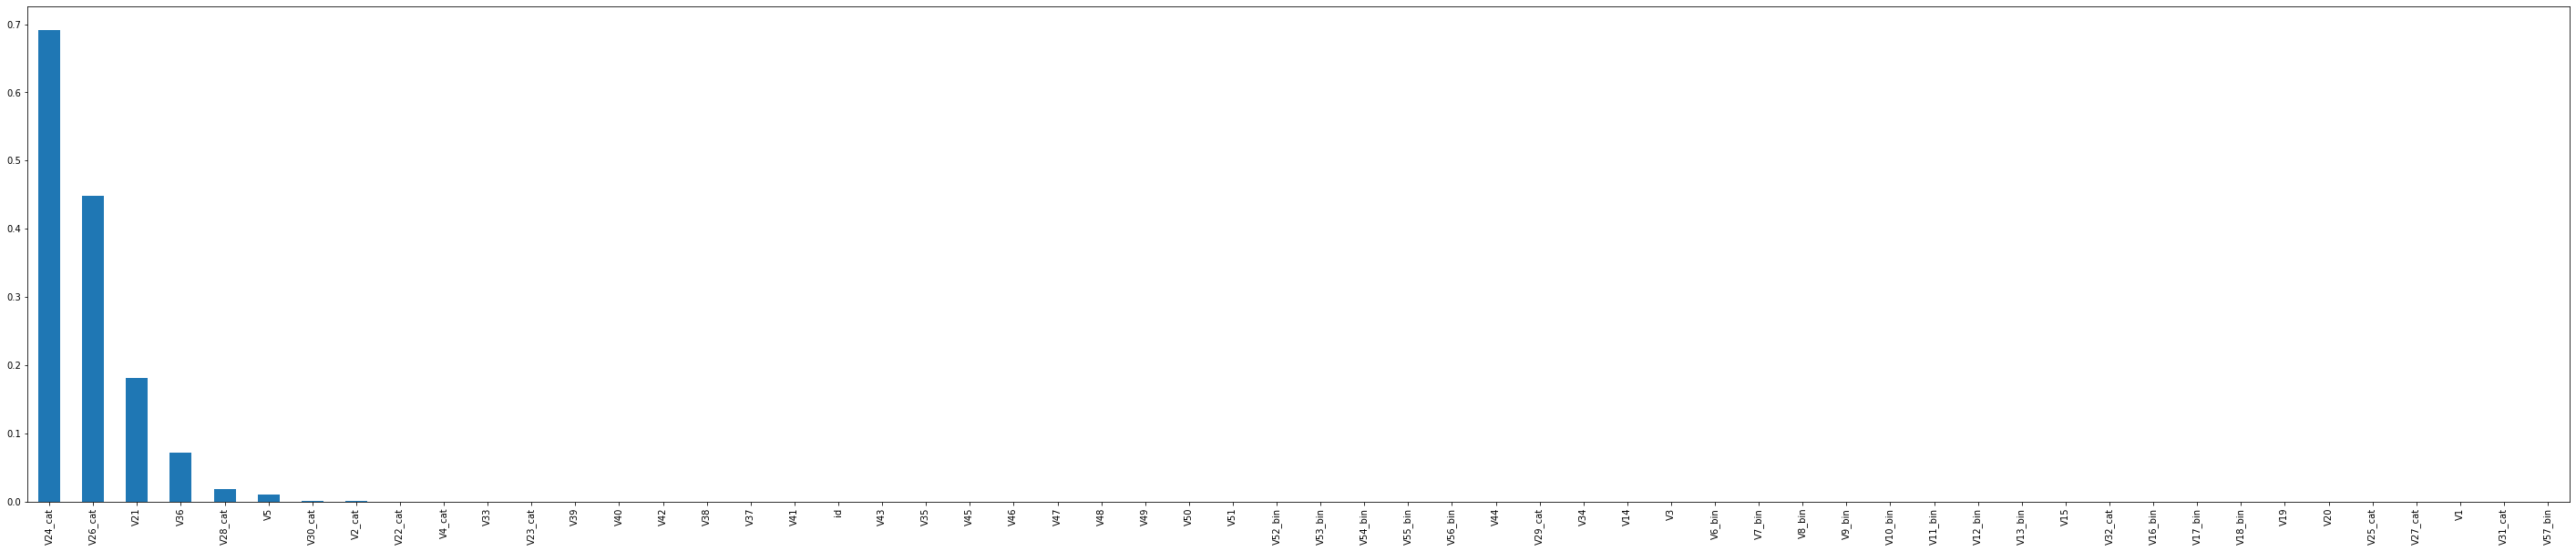

In [294]:
na_col_test.plot.bar(figsize=(50,10))
plt.show()

In [295]:
test = test.drop(['V24_cat', 'V26_cat'], axis=1) ###결측치가 너무 많은 열 제거 (data의 69%, 44%가 결측치로 이루어져 있어 유의미한 변수가 될 수 없다고 판단)

In [296]:
imputer = IterativeImputer(random_state = seed)
mice = imputer.fit(test)

final_test = pd.DataFrame(mice.transform(test))

final_test.isnull().values.any() #MICE 후 결측치 유무 확인

False

In [297]:
final_test

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,1.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.0,0.0,2.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0
1,2.0,3.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,9.0,0.0,9.0,8.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,4.0,8.0,0.0,0.0,1.0,0.0,1.0,0.0
3,4.0,1.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,8.0,0.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0,0.0
4,5.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,5.0,8.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178559,178560.0,5.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,6.0,2.0,2.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0
178560,178561.0,0.0,1.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,...,8.0,0.0,3.0,7.0,1.0,1.0,1.0,0.0,0.0,0.0
178561,178562.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,2.0,4.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0
178562,178563.0,3.0,1.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,...,5.0,0.0,3.0,8.0,0.0,1.0,0.0,1.0,1.0,0.0


In [298]:
final_test = final_test.rename(columns = {0: 'id',1:'V1',2:'V2_cat',3: 'V3', 4:'V4_cat',5: 'V5', 6:'V6_bin',7: 'V7_bin',
       8: 'V8_bin', 9: 'V9_bin',10:  'V10_bin', 11: 'V11_bin',12:  'V12_bin',13:  'V13_bin', 14: 'V14', 15: 'V15',16:  'V16_bin', 17: 'V17_bin',18:  'V18_bin',19:  'V19', 20: 'V20', 21: 'V21',22:  'V22_cat',
       23: 'V23_cat',24:  'V25_cat', 25: 'V27_cat', 26:  'V28_cat',27:  'V29_cat',28:  'V30_cat',29: 'V31_cat',30: 'V32_cat', 31: 'V33', 32: 'V34',33:  'V35',34:  'V36', 35:  'V37', 36:  'V38', 37: 'V39',
       38:  'V40', 39: 'V41',40:  'V42',41:  'V43', 42: 'V44',43:  'V45',44:  'V46',45:  'V47', 46: 'V48', 47: 'V49',48:  'V50', 49: 'V51',50:  'V52_bin',51:  'V53_bin', 52: 'V54_bin',53:  'V55_bin', 54: 'V56_bin',55: 'V57_bin'})

In [299]:
final_test_cols = list(final_test.columns)
list_binary = []
list_category = []

for col in final_test_cols:
    try:
        if col.split("_")[1] == "bin":
            list_binary.append(col)
        elif col.split("_")[1] == "cat":
            list_category.append(col)
    except:
        pass

list_numeric = list(set(final_test_cols) - set(list_binary + list_category))

In [300]:
list_category

for name in list_category:
  final_test[name] = final_test[name].astype('int')
  final_test[name] = final_test[name].astype('category')

list_category

for name in list_binary:
  final_test[name] = final_test[name].astype('int')
  final_test[name] = final_test[name].astype('category')

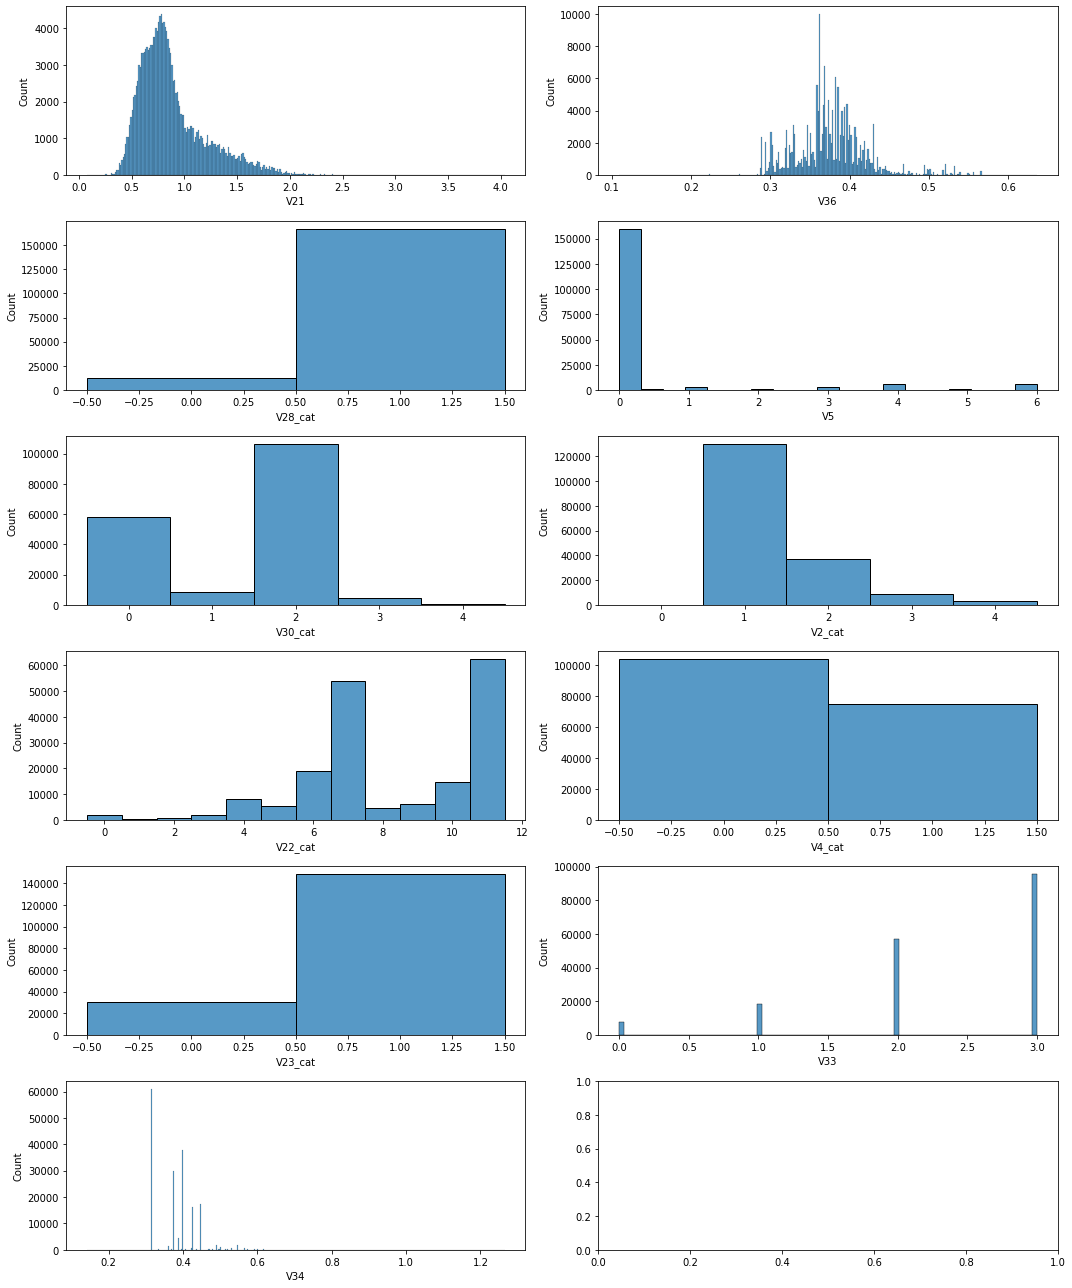

In [301]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize=(15,18))

sns.histplot(ax=axes[0,0], x="V21",data=final_test)
sns.histplot(ax=axes[0,1], x="V36", data=final_test)
sns.histplot(ax=axes[1,0], x="V28_cat", data=final_test)
sns.histplot(ax=axes[1,1], x="V5", data=final_test)
sns.histplot(ax=axes[2,0], x="V30_cat", data=final_test)
sns.histplot(ax=axes[2,1], x="V2_cat", data=final_test)
sns.histplot(ax=axes[3,0], x="V22_cat", data=final_test)
sns.histplot(ax=axes[3,1], x="V4_cat",  data=final_test)
sns.histplot(ax=axes[4,0], x="V23_cat",  data=final_test)
sns.histplot(ax=axes[4,1], x="V33",  data=final_test)
sns.histplot(ax=axes[5,0], x="V34",  data=final_test)

fig.tight_layout()

plt.show()

In [302]:
list_control = ["V4_cat", "V23_cat", "V28_cat", "V29_cat"] 
#binary data인데 category 항목에 있는 열들 ## 결측치 비율이 높았던 V24_cat, V23_cat열은 제거한 상태

### category에서 제거
for i in list_control:
    list_category.remove(i)

## binary에 추가
for i in list_control:
    list_binary.append(i)

In [303]:
## 범주형 변수 타입 변경
for name in list_category:
    final_test[name] = final_test[name].astype('category')
for name in list_binary:
    final_test[name] = final_test[name].astype('category')

In [304]:
category = final_test[list_category]
binary = final_test[list_binary]
numeric = final_test[list_numeric]
nominal = pd.concat([binary, category], axis=1)
[len(list_category), len(list_binary), len(list_numeric)]

[7, 21, 28]

In [305]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/pivot.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agged[v] = maybe_downcast_to_dtype(agged[v], data[v].dtype)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


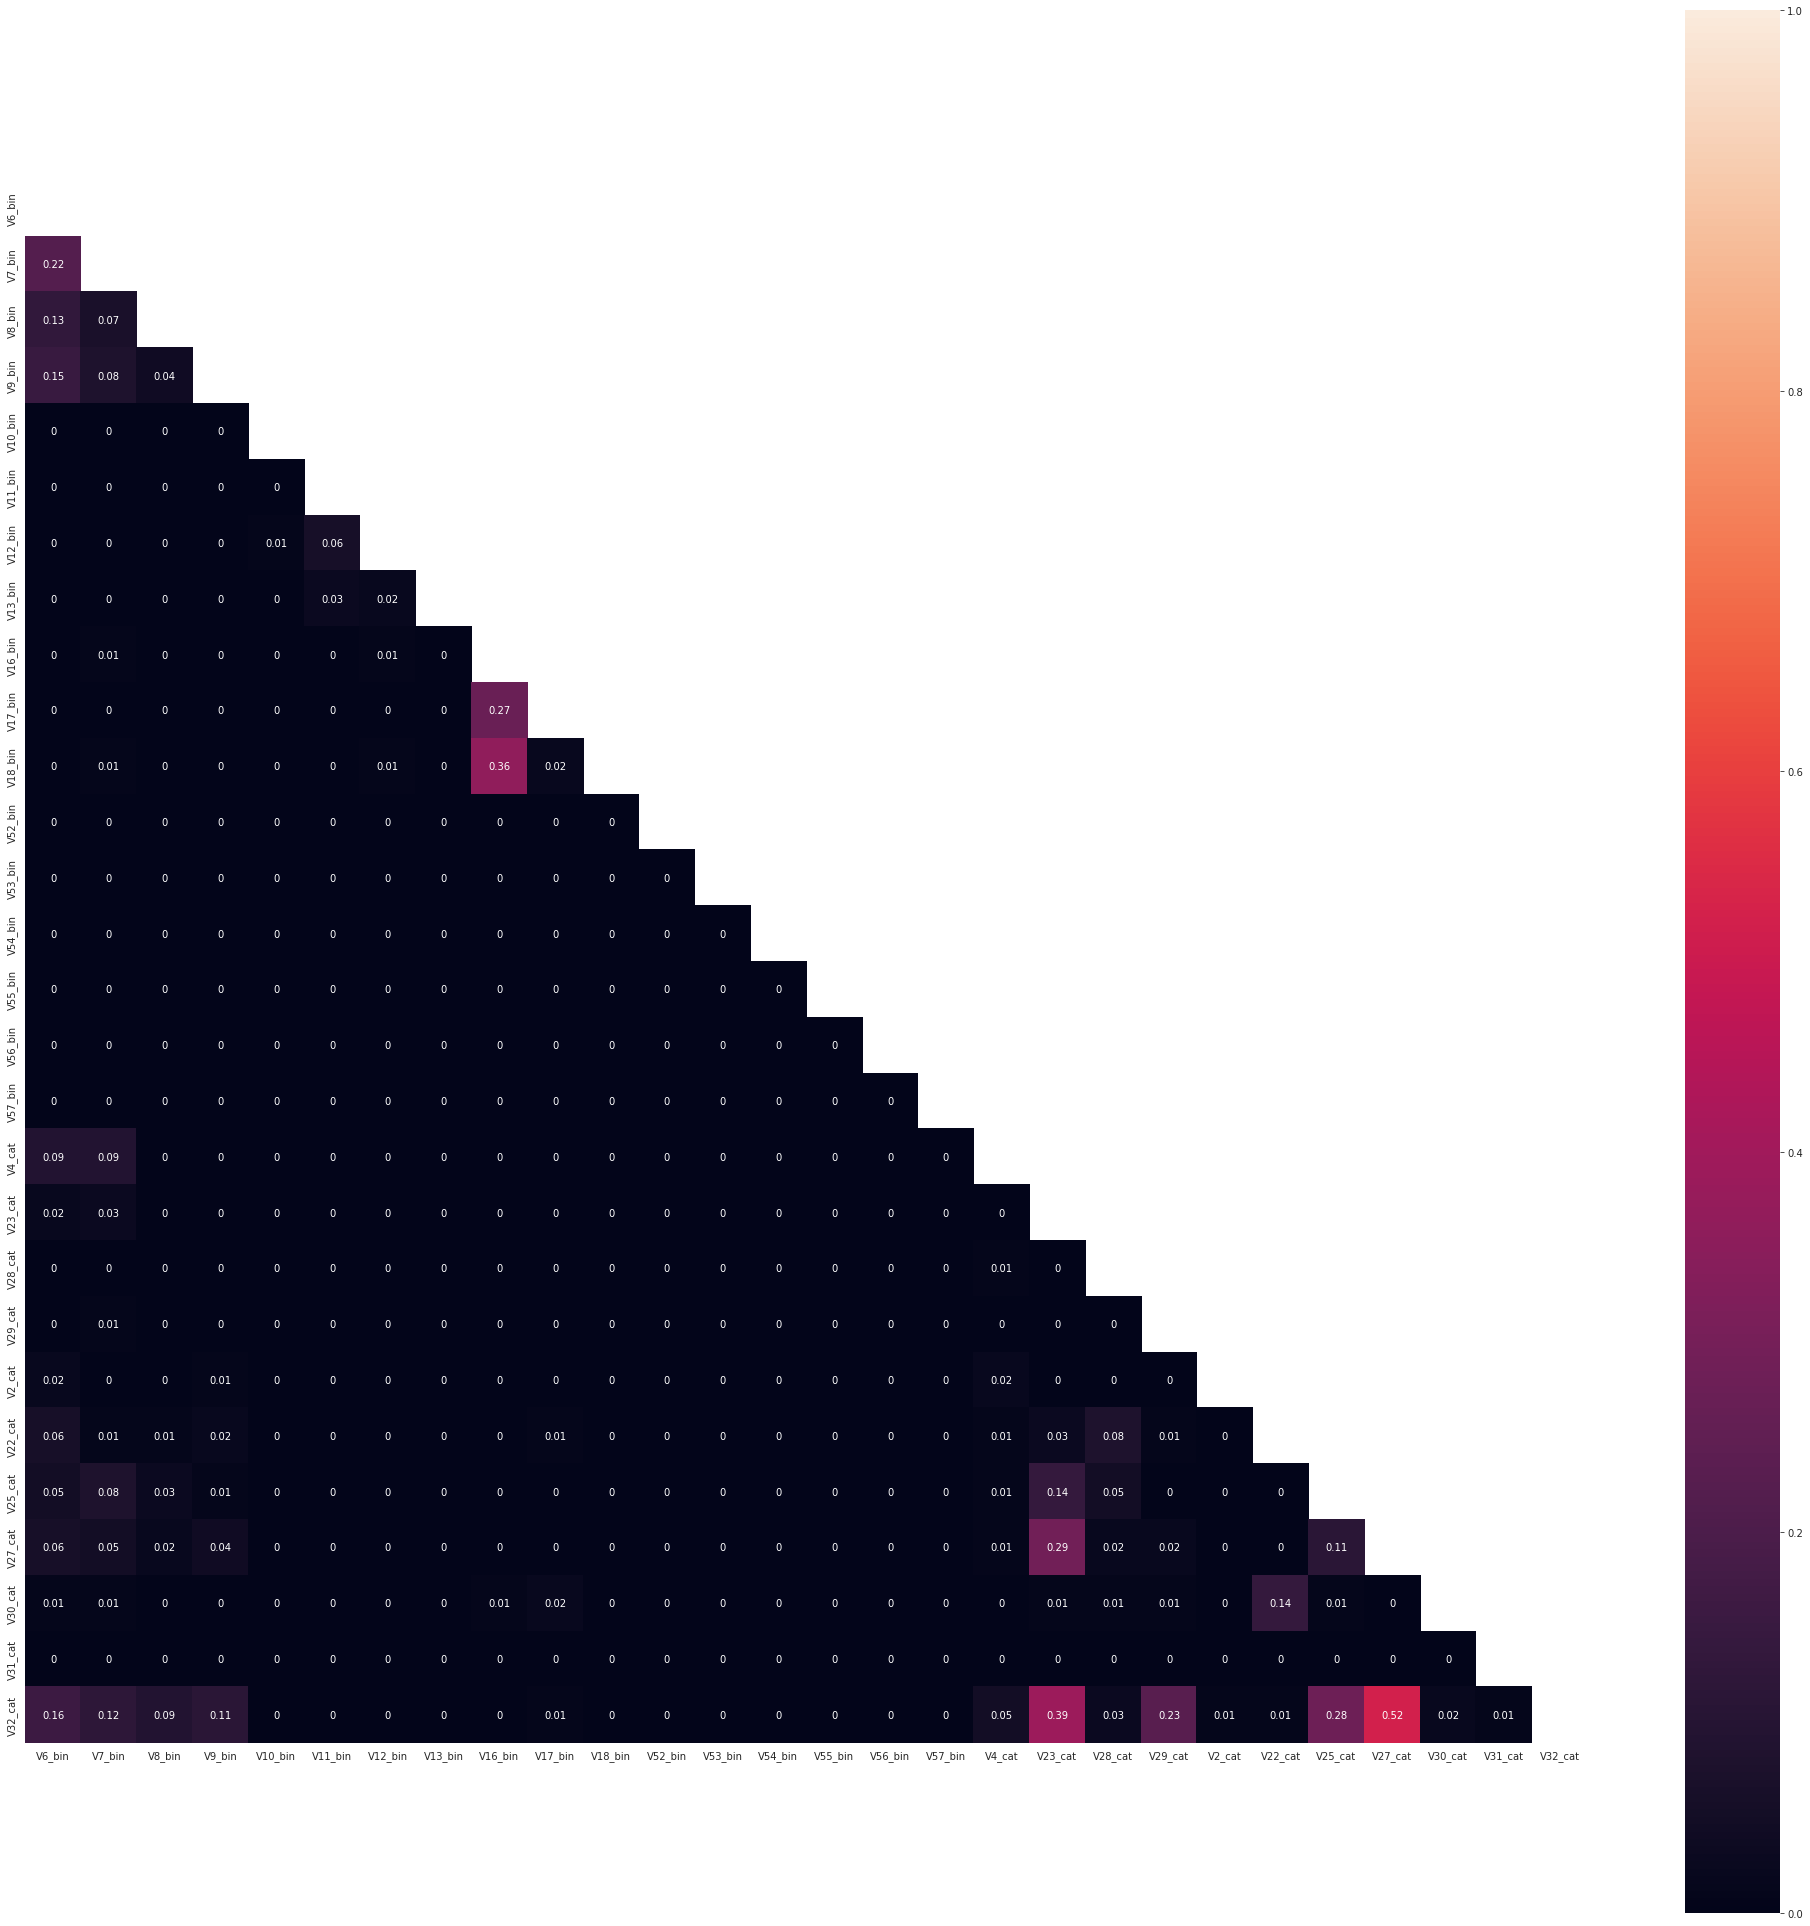

In [306]:
rows= []

for var1 in nominal:
  col = []
  for var2 in nominal :
    cramers =cramers_V(nominal[var1], nominal[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df1 = pd.DataFrame(cramers_results, columns = nominal.columns, index = nominal.columns)

mask1 = np.zeros_like(df1, dtype=np.bool)
mask1[np.triu_indices_from(mask1)] = True

plt.figure(figsize=(35,35))
with sns.axes_style("white"):
  ax = sns.heatmap(df1, mask=mask1, vmin=0., vmax=1, square=True, annot=True)
plt.show() ###제거할만한 유의미한 상관관계를 지닌 범주형 변수가 없음

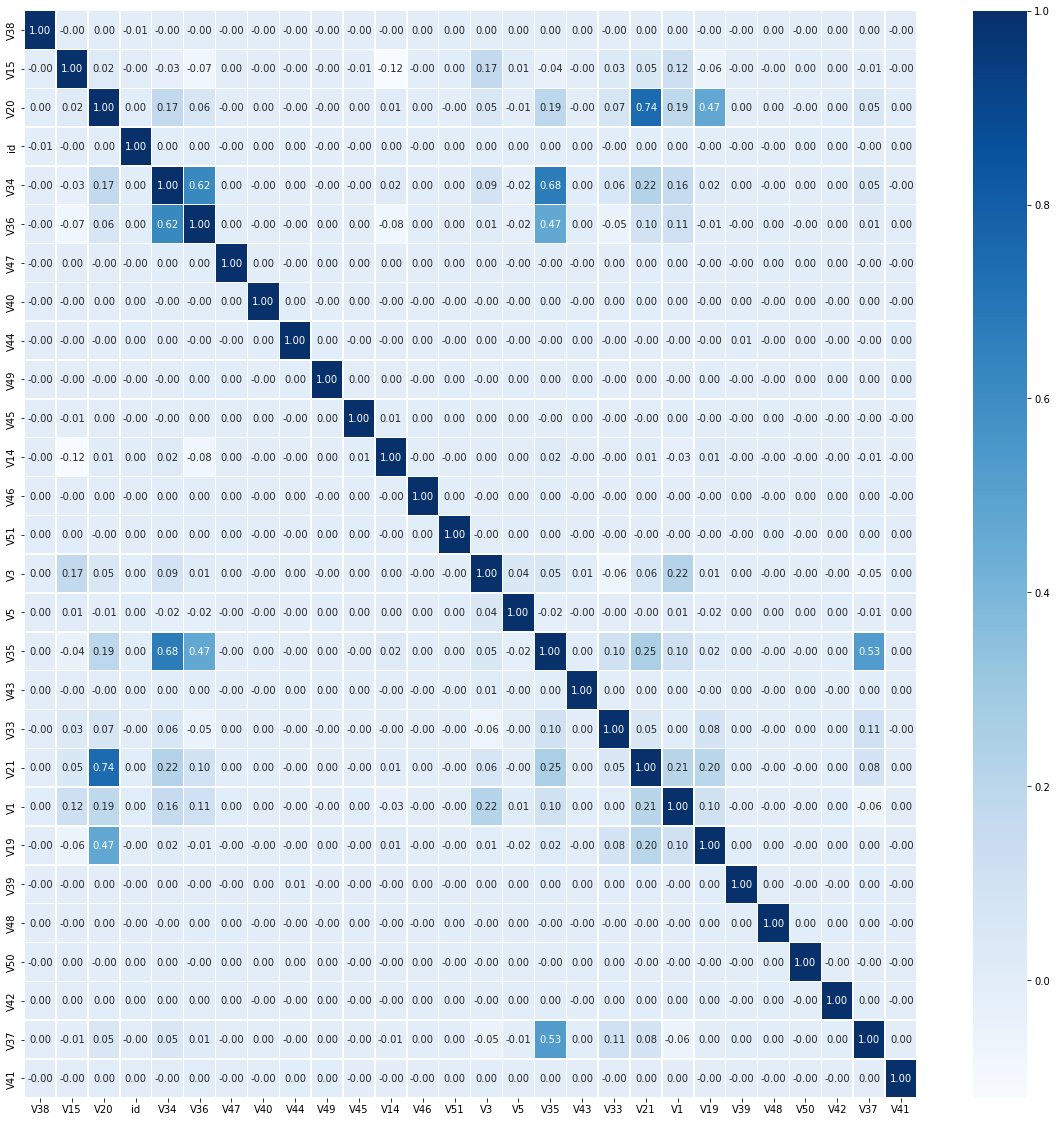

In [307]:
cor = numeric.corr(method = 'pearson')
plt.figure(figsize=(20,20))
sns.heatmap(cor, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [308]:
## categorical에서 V32_cat의 경우 hash encoding 진행

## sklearn의 HashingEncoder 사용
"""
HashingEncoder(n_components = UserNumber, cols=["User Columns"], hash_method='md5', max_process = 1)

n_components: 차원
cols: 원하는 열
max_process: 프로세스 사용 개수

#(data_set, columns = ["V32_cat"])

# X = data_set.drop("target", axis = 1)
# y = data_set["target"]
"""


X = final_test
hashencoding = HashingEncoder(cols = ["V32_cat"], n_components=5 ).fit(X)
data_hashencoding = hashencoding.transform(X)

### V32_cat 은 category 에서 제거해야지!!
list_category.remove("V32_cat") ## V32_cat은 제거한다.

In [309]:
final_test_hashencoding = data_hashencoding.rename(columns = {"col_0":"V32_cat_0", "col_1":"V32_cat_1", "col_2":"V32_cat_2", "col_3":"V32_cat_3", "col_4":"V32_cat_4"})

In [310]:
final_test_hashencoding

,V32_cat_0,V32_cat_1,V32_cat_2,V32_cat_3,V32_cat_4,id,V1,V2_cat,V3,V4_cat,...,V48,V49,V50,V51,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin
0,0,0,1,0,0,1.0,0.0,2,6.0,0,...,8.0,0.0,2.0,3.0,0,1,1,0,1,0
1,0,0,0,0,1,2.0,3.0,1,4.0,0,...,9.0,0.0,9.0,8.0,0,0,0,1,1,0
2,1,0,0,0,0,3.0,1.0,2,1.0,1,...,2.0,0.0,4.0,8.0,0,0,1,0,1,0
3,1,0,0,0,0,4.0,1.0,3,2.0,1,...,8.0,0.0,4.0,5.0,0,1,0,1,1,0
4,1,0,0,0,0,5.0,1.0,1,1.0,0,...,3.0,1.0,5.0,8.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178559,0,0,1,0,0,178560.0,5.0,1,4.0,0,...,6.0,2.0,2.0,8.0,0,0,0,1,0,0
178560,0,0,0,0,1,178561.0,0.0,1,7.0,0,...,8.0,0.0,3.0,7.0,1,1,1,0,0,0
178561,0,0,0,0,1,178562.0,5.0,3,2.0,0,...,6.0,2.0,4.0,6.0,0,1,0,0,0,0
178562,0,0,0,0,1,178563.0,3.0,1,3.0,1,...,5.0,0.0,3.0,8.0,0,1,0,1,1,0


In [311]:
final_test = final_test_hashencoding[['id',
       'V1', 'V2_cat', 'V3', 'V4_cat', 'V5', 'V6_bin', 'V7_bin',
       'V8_bin', 'V9_bin', 'V10_bin', 'V11_bin', 'V12_bin', 'V13_bin', 'V14',
       'V15', 'V16_bin', 'V17_bin', 'V18_bin', 'V19', 'V20', 'V21', 'V22_cat',
       'V23_cat', 'V25_cat', 'V27_cat', 'V28_cat', 'V29_cat',
       'V30_cat', 'V31_cat','V32_cat_0', 'V32_cat_1', 'V32_cat_2', 'V32_cat_3', 'V32_cat_4', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V41', 'V42', 
       'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52_bin', 'V53_bin', 'V54_bin', 'V55_bin','V56_bin', 'V57_bin']]

In [312]:
final_test

,id,V1,V2_cat,V3,V4_cat,V5,V6_bin,V7_bin,V8_bin,V9_bin,...,V48,V49,V50,V51,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin
0,1.0,0.0,2,6.0,0,0.0,0,0,0,1,...,8.0,0.0,2.0,3.0,0,1,1,0,1,0
1,2.0,3.0,1,4.0,0,0.0,1,0,0,0,...,9.0,0.0,9.0,8.0,0,0,0,1,1,0
2,3.0,1.0,2,1.0,1,0.0,0,0,0,1,...,2.0,0.0,4.0,8.0,0,0,1,0,1,0
3,4.0,1.0,3,2.0,1,0.0,1,0,0,0,...,8.0,0.0,4.0,5.0,0,1,0,1,1,0
4,5.0,1.0,1,1.0,0,0.0,0,1,0,0,...,3.0,1.0,5.0,8.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178559,178560.0,5.0,1,4.0,0,0.0,0,1,0,0,...,6.0,2.0,2.0,8.0,0,0,0,1,0,0
178560,178561.0,0.0,1,7.0,0,0.0,0,1,0,0,...,8.0,0.0,3.0,7.0,1,1,1,0,0,0
178561,178562.0,5.0,3,2.0,0,0.0,0,0,1,0,...,6.0,2.0,4.0,6.0,0,1,0,0,0,0
178562,178563.0,3.0,1,3.0,1,0.0,0,0,1,0,...,5.0,0.0,3.0,8.0,0,1,0,1,1,0


In [313]:
final_test.to_csv('final_test.csv', index = False)